<a href="https://colab.research.google.com/github/fisherj1/Neural/blob/Lesson8/Lesson_09_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Занятие 10 - Вариационный автоэнкодер (VAE)

## Структура и обучение автоэнкодера.
Autoencoder - архитектура нейросети, которая сначала с помощью Энкодера сжимает изображение в вектор небольшой размерности(он называется скрытым представлением), а затем восстанавливает этот вектор в исходную картинку. Казалось бы, зачем это нужно? Вход и выход этой нейросети - одна и та-же картинка, ничего нового она не создаёт. Однако практика показывает, что скрытое представление картинки позволяет делать очень интересные и красивые вещи - например, гладкую интерполяцию между 2 написанными от руки цифрами. Более того, Autoencoder можно даже обучить очищать изображения от шума.

Откуда берутся эти свойства? Они являются следствие сжатия информации. Одна из форм сжатия это классификация, котрую мы уже делали. Если это цифры, то вместо изображения можно сохранить только какая это цифра. Это предельное сжатие информации, но при попытке перевести цифру в картинку мы уже не имеем достаточно информации, чтобы картинка получалось разной. Если не так сильно ограничивать информацию в точке максимального сжатия, то кроме класса цифры сохранится еще что-то и изображение удастся восстановить с большим количеством сохранённых деталей.
![alt text](http://fastforwardlabs.github.io/blog-images/miriam/imgs_code/vae.4.png)

## Сжатие информации и потери
Автоэнкодер может быть без потерь и с потерями (lossless и lossy). В какой-то степени это альтернативно методам сжатия архиваторов и кодирования контента (zip, mp3, jpeg, flac, ...). Можно ли сделать сжатие на нейронных сетях с помощью автоэнкодеров? Да, это будет работать. Размер сети будет большим, но сжатие может превзойти другие алгоритмы. Исследования в этой области ведутся, но практически применямых примеров я не знаю.
![alt text](https://miro.medium.com/max/1395/1*UdOybs9wOe3zW8vDAfj9VA@2x.png)

## Метод главных компонент (PCA). Аналогия AE и PCA
Метод главных компонент (Principal Component Analysis). Это метод отображения векторов свойств объектов (помним, что у нас объект всегда описывается вектором свойств, длина вектора это количество свойств) в вектора производных свойств, меньшей длины с помощью линейной комбинации, чтобы обратной операцией можно было восстановить значения векторов свойств как можно ближе к исходным. То есть PCA тоже выполняет сжатие информации, от тоже работает для группы объектов (а нейронная сеть автоэнкодера учится под определённую группу объектов). Отличие PCA и AE в том, что PCA выполняет линейную комбинацию над компонентами исходного вектора свойств объекта, а AE - как правило, нелинейную. PCA вычисляется однозначно, а AE обучается без гарантии нахождения наилучшего положения. PCA гарантирует ортогональный базис для разложения сжатых свойств, а AE - нет.

Графически можно представить PCA, как поиск подпространства, проекция точек на которое минимально меняет координаты в исходном пространстве. Например для объектов на плоскости PCA можно сделать в одномерное пространство - на прямую.
![alt text](https://miro.medium.com/max/1395/1*ayo0n2zq_gy7VERYmp4lrA@2x.png)
Прямая определяется только вектором нормали, то есть линия проекции проходит через 0. Исходные множества надо центрировать перед операцией PCA.

PCA будет частным случаем AE если в нём сделать только один плотный слой (Dense) с количеством нейронов, равным размерности сжатого состояния, сделать линейную функцию активации, сделать потери по среднему квадрату ошибки (mean squared error - MSE). Тогда PCA позволяет рассчитать веса для нейронов такого автоэнкодера. При этом гарантировав наилучшее решение задачи.

## Очищение изображения от шумов
Интересное применение Autoencoder'ов - очищение входной картинки от шумов. Такое принципиально возможно из-за того, что размерность латентного пространства очень мала по сравнению с размерностью входного пространства(в нашем случае - 32 и 784 соответственно) - в нём попросту нет места случайному шуму, но зато есть место для общих закономерностей из входного пространства.
То есть мы подаём на обучении автоэнкодера такой незашумлённый датасет, что в нём на самом деле есть некое простраство свойств, которое его описывает. На выходе энкодера в изображении останутся именно эти свойства. Шум является внешним свойством и не сможет закодироваться.

Давайте применим PCA, как простеший автоэнкодер, для очищения от шумов изображений базы MNIST. Нам потребуется база MNIST, numpy, библиотека отрисовки matplotlib и сам PCA, который есть в пакете sklearn.

In [1]:
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import time

Загрузим данные и приведём размерность к двумерной, чтобы это был набор векторов свойств.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255., x_test/255.
xt_shape = x_train.shape
print("Initial shape ", xt_shape)
xt_flat = x_train.reshape(-1, xt_shape[1]*xt_shape[2])
print("Reshaped to ", xt_flat.shape)

11493376/11490434 [==============================] - 0s 0us/step
Initial shape  (60000, 28, 28)
Reshaped to  (60000, 784)


Теперь заведём класс PCA и настроим его, чтобы сохранял 95% исходной картинки. Обучим его и посмотрим сколько ему потребовалось свойств для описания каждой картинки.

In [3]:
pca = PCA(.90)
xt_encoded = pca.fit_transform(xt_flat)
print("Encoded features ", pca.n_components_)

Encoded features  87


Энкодер (он же декодер, ведь это просто обратная матрица от энкодера PCA) обучен. Теперь можно проверить, как он закодирует и раскодирует тестовую выборку. Для этого проведём такие же преобразования размерности для неё.

In [4]:
xtest_shape = x_test.shape
xtest_flat = x_test.reshape(-1, xtest_shape[1]*xtest_shape[2])
xtest_encoded = pca.transform(xtest_flat)
xtest_decoded = pca.inverse_transform(xtest_encoded).reshape(xtest_shape)
print("Decoded xtest_decoded shape is ", xtest_decoded.shape)

Decoded xtest_decoded shape is  (10000, 28, 28)


Теперь нужно определить функцию для отрисовки изображений MNIST. Она будет выводить несколько изображений в ряд, поэтому будет принимать трёхмерный массив. Шкала не должна быть автоподстраиваемой, так как после обработки изображения выйдут за диапазон (0,1), в котором заданы исходные изображения. Мы зафиксируем шкалу в диапазоне (0,1).

In [5]:
def plot_images(images, title):
    fig=plt.figure(figsize=(16, 3))
    columns = images.shape[0]
    rows = 1
    for i in range(columns):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(images[i], cmap='gray_r', clim=(0,1))
    fig.suptitle(title)
    plt.show()

Выведем исходное и закодированное изображение для некоторых изображений, которые мы элегантно случайным образом выберем из всей тестовой выборки.

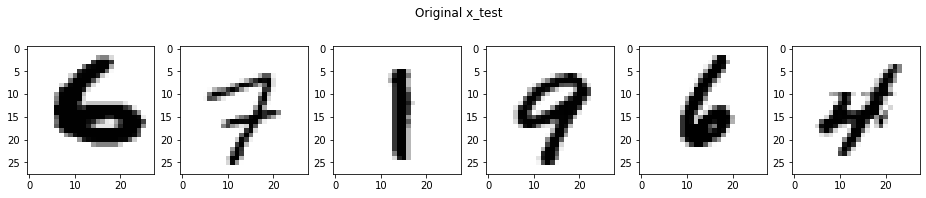

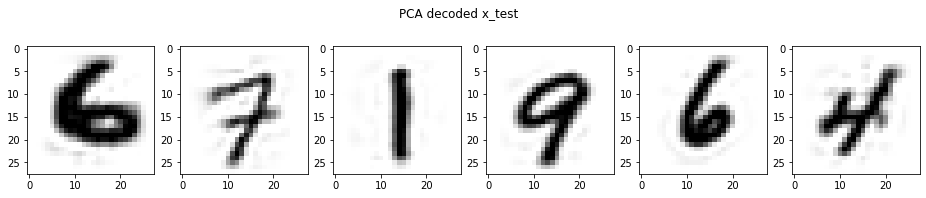

In [11]:
sample_indices = np.random.choice(x_test.shape[0], 6)
samples_orig = x_test[sample_indices]
samples_decoded = xtest_decoded[sample_indices]
plot_images(samples_orig, "Original x_test")
plot_images(samples_decoded, "PCA decoded x_test")

Видно, что `pca.n_components_` (87 для 90% PCA) достаточно для описания картинок MNIST вместо 784 исходных пикселей. Но при этом нужно хранить матрицу кодирования-декодирования, а также изображения получаются немного зашумлёнными. Мы получили способ сжатия с потерями для рукописных цифр, где изображение центрировано и отмасштабировано по рамке из 28х28 пикселей (подробней смотри правила базы MNIST). Степень сжатия у нас условно 87/784 ~= 0.11. То есть сжатие в 9 раз. "Условно", так как сжатое изображение хранится во float, а исходное в uint8, который требует в 4 раза меньше байт. Можешь сам на досуге сравнить какое качество изображения будет при аналогичном сжатии JPEG.

Теперь посмотрим как наш автоэнкодер без нейросетей справится с очисткой от зашумления. Для этого сделаем функцию добавления шумов к MNIST выборке и посмотрим результат.

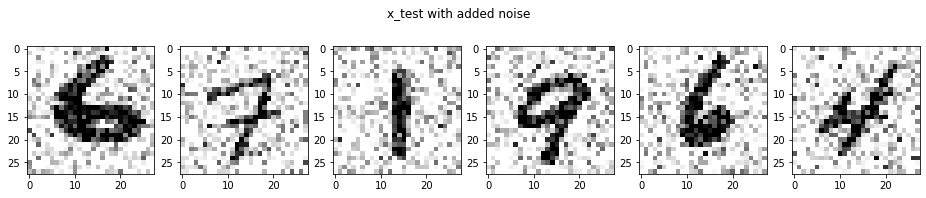

In [12]:
def mnist_add_noise(noise_factor, dataset):
    return dataset + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dataset.shape) 

x_test_noisy = mnist_add_noise(0.3, x_test)
samples_noisy = x_test_noisy[sample_indices]
plot_images(samples_noisy, "x_test with added noise")

Теперь нужно провести ту же операцию PCA энкодера и декодера, что выше.

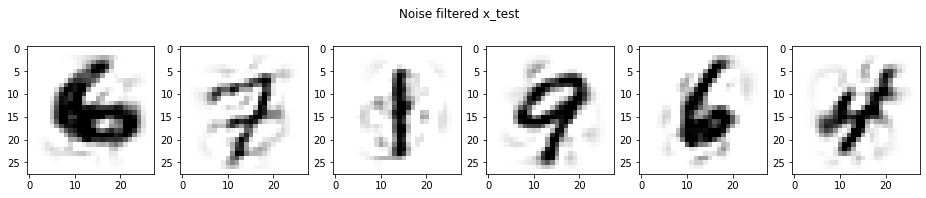

In [13]:
def PCArecode(dataset):
    dataset_flat = dataset.reshape(-1, dataset.shape[1]*dataset.shape[2])
    return pca.inverse_transform(pca.transform(dataset_flat)).reshape(dataset.shape)

x_filtered = PCArecode(x_test_noisy)
samples_filtered = x_filtered[sample_indices]
plot_images(samples_filtered, "Noise filtered x_test")

Итак, шумы стали значительно меньше, но и артефакты вокруг цифры усилились. Это неудивительно, ведь мы сжимали информацию линейным образом на целых 87 компоненты. Это не позволяет ни глубокого обучения, ни достаточного сжатия. Повышение уровня сжатия приведёт к еще большему количеству артефактов.

## Обучение автоэнкодера
Итак, вспомним, что в автоэнкодере одна сеть переводит пространство свойств в пространство меньшей размерности, а другая сеть восстанавливает исходное изображение. Вместо вычисления коэффициентов сети мы будем её обучать. Для обучения нужно определить функцию потерь. Мы возьмём среднеквадратичное расстояние (MSE). То есть мы требуем, чтобы значения пикселей исходного изображения и восстановленного отличались несильно.
![alt_text](https://miro.medium.com/max/977/1*bY_ShNK6lBCQ3D9LYIfwJg@2x.png)
Мы можем использовать любую сеть для энкодера и декодера: на плотных слоя или на свёрточных.

Обучим автоэнкодер и посмотрим на качество декодирования изображений. Начнём с импорта стандартного набора библиотек. Теперь нам потребуется tensorflow с его плотными, свёрточными и другими стандартными слоями.

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Dropout, Input, LeakyReLU, Flatten, Reshape
from tensorflow.keras.models import Model, Sequential

### Фикс для GPU
Для видеокарт с 4 ГБ памяти и меньше tensorflow оставляет недостаточный запас свободной видеопамяти, поэтому включим выделение памяти по требованию, вместо дефолтной процеду выделения сразу почти всей памяти.

In [15]:
gpus = tf.config.experimental.list_physical_devices("GPU")
try:
    logical_gpus = tf.config.experimental.list_logical_devices("GPU")
    print(f"Physical GPUs {len(gpus)}\nLogical GPUs {len(logical_gpus)}")
except RuntimeError as e:
    print(e)

Physical GPUs 1
Logical GPUs 1


Теперь нужно задать архитектуру модели. Мы будем использовать последовательную модель и свёрточную  архитектуру. В конце должен быть вектор длины `latent_size`.

In [16]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# Convolutional layers require 4th dimension
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

AE_latent_size = 24

# Create Encoder
def getEncoder(latent_size):
  model = Sequential([
      Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)),
      LeakyReLU(0.2),
      Conv2D(32, (3, 3), padding='same'),
      LeakyReLU(0.2),
      MaxPooling2D((2, 2), padding='same'),
      Conv2D(64, (3, 3), padding='same'),
      LeakyReLU(0.2),
      Conv2D(64, (3, 3), padding='same'),
      LeakyReLU(0.2),
      MaxPooling2D((2, 2), padding='same'),
      Flatten(),
      Dense(units=latent_size)
  ])
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model

# Create Decoder
def getDecoder(latent_size):
  model = Sequential([
      Dense(units=7*7*64, input_dim=latent_size),
      Reshape((7, 7, 64), input_shape=(7*7*64,)),
      UpSampling2D((2, 2)),
      Conv2D(64, (3, 3), padding='same'),
      LeakyReLU(0.2),
      Conv2D(64, (3, 3), padding='same'),
      LeakyReLU(0.2),
      UpSampling2D((2, 2)),
      Conv2D(32, (3, 3), padding='same'),
      LeakyReLU(0.2),
      Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
  ])
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model

Теперь создадим автоэнкодер функциональным способом и установим ему функцию потерь MSE и наш стандартный оптимизатор - Adam. Обучим его батчами по 64 элемента и 10 эпох хватит с запасом. Напомним, что обучаем мы его восстанавливать исходную картинку, поэтому как input, так и label будет равен x_train.

In [13]:
encoder = getEncoder(AE_latent_size)
decoder = getDecoder(AE_latent_size)

autoencoder_input = Input(shape=(28, 28, 1)) # Set shape to (28, 28, 1) if autoencoder is convolutional, (784, 1) otherwise
latent = encoder(autoencoder_input)
autoencoder_output= decoder(latent)
autoencoder = Model(inputs=autoencoder_input, outputs=autoencoder_output)
autoencoder.compile(loss='mse', optimizer='adam')
history = autoencoder.fit(x_train, x_train, batch_size=64, epochs=10)

Epoch 1/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0151
Epoch 2/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0057
Epoch 3/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0050
Epoch 4/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0046
Epoch 5/10
938/938 [==============================] - 11s 11ms/step - loss: 0.0043
Epoch 6/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0042
Epoch 7/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0040
Epoch 8/10
938/938 [==============================] - 11s 11ms/step - loss: 0.0039
Epoch 9/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0038
Epoch 10/10
938/938 [==============================] - 11s 11ms/step - loss: 0.0037


Всё готово и можно сделать процедуру, как с PCA по кодированию и декодированию. Мы использовали дополнительную размерность для свёрточных сетей, поэтому надо будет её убрать.

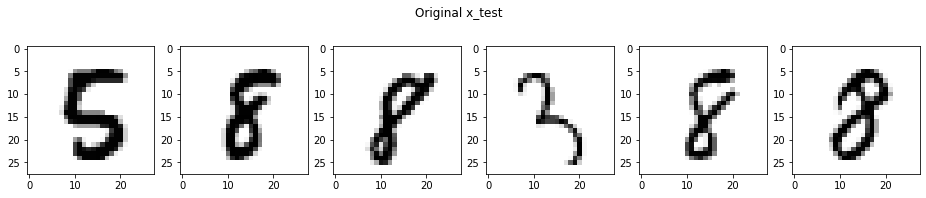

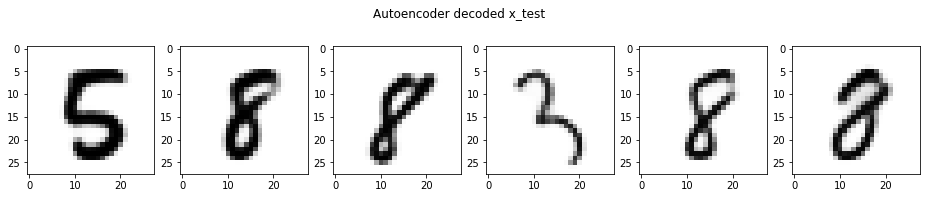

In [14]:
samples_decoded = np.squeeze(autoencoder.predict(x_test[sample_indices]), axis = 3)
plot_images(samples_orig, "Original x_test")
plot_images(samples_decoded, "Autoencoder decoded x_test")

Качество сжатия мы оценили визуально выше. Если обратить внимание, то исходные картинки даже почистились от мелких шумов и странностей изображения и больше стали похожи на непрерывные линии. Размерность латентного пространства `latent_size` значительно меньше исходного количества свойств (784), поэтому мы получили неплохое сжатие изображения. И для этого нам потребовалась модель decoder, в которой есть коэффициенты. Посмотрим размер моделей.

In [15]:
autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 24)                140280    
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         171009    
Total params: 311,289
Trainable params: 311,289
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
____________________________

## Автоэнкодер, как генератор и его ограничения. Плавная интерполяция
У нас уже была система с латентным пространством и возможностью строить по нему объекты - GAN. Значит в случае автоэнкодеров тоже можно подавать случайный вектор на декодер и получать новые объекты. До этого мы же только восстанавливали исходную картинку.
![alt text](https://miro.medium.com/max/977/1*Qd1xKV9o-AnWtfIDhhNdFg@2x.png)
Какое значение вектора выбрать? Мы же никак не управляли латентным пространством. Непонятно какие числа подставлять. Поэтому мы можем выбрать промежуточные значения между двумя представлением двух исходных изображений в латентном пространстве и получить плавную интерполяцию между изображениями. Постепенно свойства одного изображения будут исчезать, а появляться свойства другого.

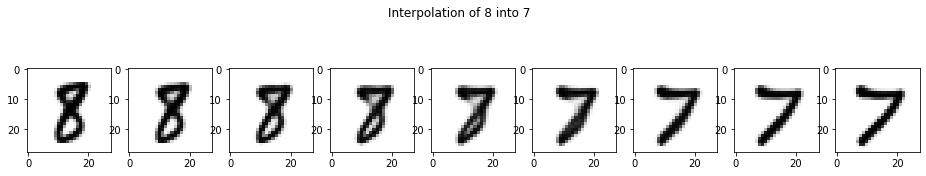

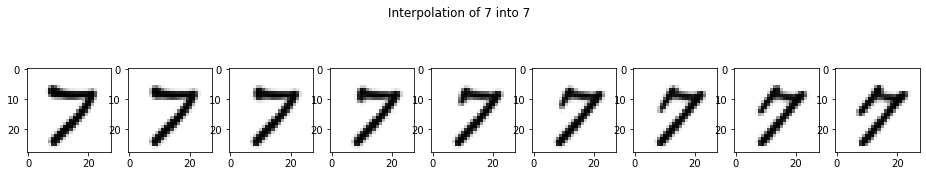

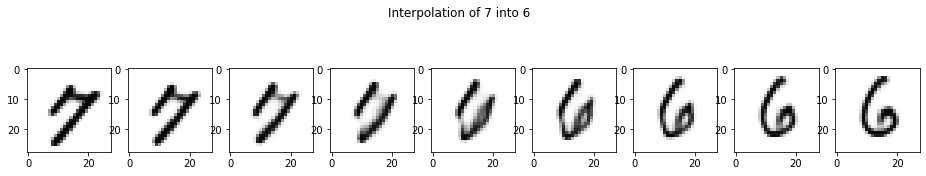

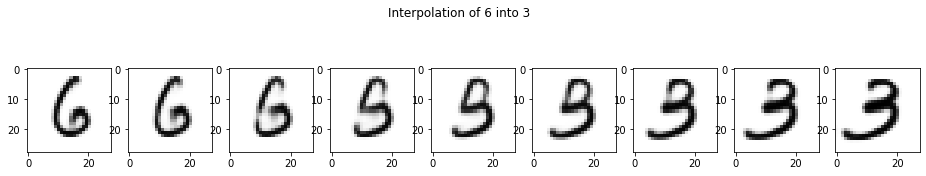

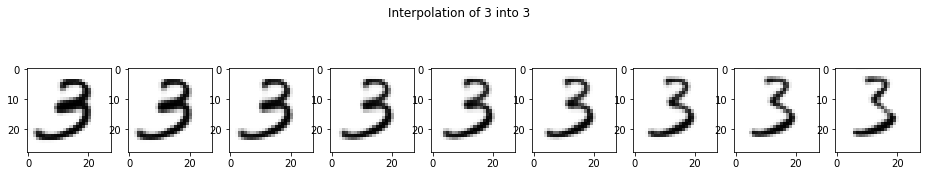

In [16]:
def interpolation(vec1, vec2, N_inter):
    intermediate_values = np.zeros((0, vec1.shape[0]))
    for i in range(N_inter):
        intermediate = (1-float(i / N_inter))*vec1 + float(i / N_inter)*vec2
        intermediate_values = np.append(intermediate_values, intermediate.reshape(1, -1), axis=0)
    intermediate_values = np.append(intermediate_values, vec2.reshape(1, -1), axis=0)
    return intermediate_values

N_inter = 8

# Take pairs of random images from the test set
encodings = encoder.predict(np.expand_dims(samples_orig, axis = 3))
for i in range(len(sample_indices) - 1):
    vectors = interpolation(encodings[i], encodings[i+1], N_inter)
    images = np.squeeze(decoder.predict(vectors), axis = 3)
    plot_images(images, "Interpolation of %i into %i"%(y_test[sample_indices[i]], y_test[sample_indices[i+1]]))

Если этот файл запущен не на Google Colab, с помощью этого кода можно создать видео, на котором процесс превращения одной цифры в другую будет виден ещё более наглядно. Для этого можно использовать уже известный нам OpenCV. Он умеет делать видеофайлы из массивов чисел.

In [17]:
import cv2

N_inter = 90
resize_coeff = 10

size = (images.shape[2]*resize_coeff, images.shape[1]*resize_coeff)
out = cv2.VideoWriter('output/interpolation.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, size, 0)
for i in range(len(sample_indices) - 1):
    vectors = interpolation(encodings[i], encodings[i+1], N_inter)
    images = np.squeeze(decoder.predict(vectors), axis = 3)
    for i in range(len(images)):
        img = images[i] / np.max(images[i])
        img = (cv2.resize(255*img.reshape(28, 28), size, cv2.INTER_NEAREST))
        out.write(img.astype(np.uint8))
    
out.release()

Так себе интерполяция вышла. Старое изображение затухает, а новое изображение появляется. Хочется, чтобы в промежуточных кадрах не было каки-то непонятных очертаний, а изображение было чем-то промежуточным по смыслу между стартовым и конечным изображением. Причина в том, что в латентном пространстве действительно возникли зоны, которые умеют декодироваться в хорошие изображения. Но никто не сказал, что между этими зонами должно быть что-то адекватное.
Представим это графически. Пусть наш очень умный, содержащий очень много коэффициентов, энкодер и декодер смог разложить все входные объекты на одной оси (размерность латентного пространства - 1). По сути он каждому входному изображению присвоил номер и по номеру может это изображение вспомнить. То есть автоэнкодер очень переобученный. Тогда если мы возьмём промежуточный номер (пытаемся интерполировать), то какое изображение мы собираемся получить?
![https://miro.medium.com/max/1395/1*iSfaVxcGi_ELkKgAG0YRlQ@2x.png](https://miro.medium.com/max/1395/1*iSfaVxcGi_ELkKgAG0YRlQ@2x.png)

Если мы хотим, чтобы декодированные промежуточные латентные состояния имели черты близких к ним объектов, то надо притянуть латентные координаты похожих объектов. Например вот так:
![https://miro.medium.com/max/1395/1*83S0T8IEJyudR_I5rI9now@2x.png](https://miro.medium.com/max/1395/1*83S0T8IEJyudR_I5rI9now@2x.png)

## Вариационный автоэнкодер
Мы приходим к определению вариационного автоэнкодера. Это автоэнкодер, обучение которого подверглось регуляризации с целью предотвращения переобучения и обеспечения хороших возможностей по генерации. То есть вариационный автоэнкодер (variational autoencoder - VAE) это то, что нам нужно для задачи интерполяции. А регуляризация это метод. которым мы воспользуемся. Вспомним что такое регуляризация: это дополнительное слагаемое к функции потерь для которой решается задача минимизации. регуляризация позволяет делать селекцию решений, убирая неудобные чем-то решения. Нам нужна функция, которая будет малой, только если латентное представление будет расположенным плотно, когда близкие по свойствам классы расположены близко друг к другу.

То есть мы должны представление объектов в латентном пространстве слева перевести в представление справа, хотя оба представления успешно справляются с задачей автоэнкодера по восстановлению изображений.
![https://miro.medium.com/max/1395/1*9ouOKh2w-b3NNOVx4Mw9bg@2x.png](https://miro.medium.com/max/1395/1*9ouOKh2w-b3NNOVx4Mw9bg@2x.png)

Идеальная картина будет такая:
![https://miro.medium.com/max/977/1*79AzftDm7WcQ9OfRH5Y-6g@2x.png](https://miro.medium.com/max/977/1*79AzftDm7WcQ9OfRH5Y-6g@2x.png)

## Регуляризация: лассо-регрессия и гребневая регрессия
Для уменьшения значения параметров по модулю подходят простые функции модуля и квадрата. Обе монотонно убывают, когда параметры стремятся к нулю из положительных или отрицательных направлений. Можно построить регуляризацию на любой из них, дав ей какой-то вес и добавив к функции потерь. Аргументами функции будут выходы последнего слоя энкодера, то есть представление объекта в латентном пространстве. Таким образом, мы введём регуляризацию, пессимизируя попадание объектов далеко от начала координат.

Модуль от значения аргумента называют L1 регуляризацией или лассо-регрессией. Эта регуляризация обычно довольно агрессивная и в многомерном пространстве приводит к отбору свойств или признаков объекта, обращая малозначимые коэффициенты под регуляризацией в ноль. То есть если надо минимизировать сумму модулей, то лучше удержать какой-то параметр на величину 'a', но свести малозначимый параметр со значением 'a' до нуля (меньше потери по нему уже не сделать). Последний параметр перестанет действовать, но зато более значимый параметр не пострадает.

Квадрат от значения аргумента называют L2 регуляризацией или гребневой регрессией. У неё нет свойства отбирать одни признаки против других, так как по мере приближения к нулю параболическая зависимость начинает давать мало вклада в потери, а вклад в основном приходит от больших аргументов.

Значит нужно взять выходы энкодера и вызвать добавочные потери по ним. Для этого существуют функции из документации https://keras.io/api/layers/regularizers/ . Однако попытка уменьшить значения в латентном пространстве просто приведёт к его масштабированию. Нужно заставить распределение попадать в некоторые рамки. Это проиллюстрировано ниже.

![alt text](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-18-at-7.22.24-PM.png)

Мы имеем ситуацию, как на картинке слева. Переход-интерполяция между объектами проходит через зону отсутствующих в обучении объектов, декодирование которых даст несуществующие в реальности объекты. Нам не удастся погенерировать новые картинки, преобразовывая случайную точку из латентного пространства в случайную картинку. Мы хотим иметь плотное распределение, как на средней картинке (KL divergence - об этом позже), но только там классы перепутаны между собой. Значит нам нужно требовать представление в латентном пространстве размещать в виде нормального распределения, но еще и не давать разным классам перемешиваться.

## Вероятностный автоэнкодер
Сейчас мы сделаем математический трюк и перейдём от детерминистского энкодера и декодера, которые каждому объекту сопоставляет точку латентного пространства и наборот, к вероятностным энкодеру и декодеру. Энкодер для каждого объекта генерирует параметры нормального распределения в латентном пространстве, где можно расположить закодированный объект, а декодер использует вероятностное распределение, чтобы выбрать точку в латентном пространстве и декодировать её в исходное изображение, насколько это у него получится.
![https://miro.medium.com/max/977/1*Q5dogodt3wzKKktE0v3dMQ@2x.png](https://miro.medium.com/max/977/1*Q5dogodt3wzKKktE0v3dMQ@2x.png)

Но если просто применить такой принцип, то он снова имеет проблему предыдущего детерминистического подхода, так как вероятностное распределение сможет свернуться в дельта-функцию. Поэтому нам надо ввести регуляризацию, требующую от каждого распределения быть близким к нормальному распределению вокруг нуля координат латентного пространства с дисперсией 1. Но что такое близость двух вероятностных распределений?

## Дивергенция Кульбака-Лейблера
Проблема измерения расстояния, отличия вероятностных распределений ставится в многих задачах. Например в теории информации для определения дополнительной длины сообщения для передачи информации с одним вероятностным распределением, закодированной неоптимальным кодом - сделанным для другого вероятностного распределения.

Для этих задач традиционно применяют дивергенцию Кульбака-Лейблера, которая является несимметричной. Расстояние от распределения p до q не равно расстоянию от q до p. Поэтому первое распределение обычно предполагается истинным, а второе проверяемым. Проверяемое, совпадающее с истинным должно давать нулевую дивергенцию.

Подробней можно посмотреть в википедии, но на самом деле нам подойдёт любая адекватная мера расстояния.

## Генерация нормальных распределений
Итак, мы должны поменять наш энкодер, чтобы он выдавал параметры нормального распределения. Их 2 - среднее и дисперсия. Мы будем считать, что матрица ковариации диагональная. Значит нам нужно в 2 раза больше параметров. Сделаем такой энкодер, поменяв выходной слой.
![https://miro.medium.com/max/977/1*XYyWimolMhPDMg8qCNlcwg@2x.png](https://miro.medium.com/max/977/1*XYyWimolMhPDMg8qCNlcwg@2x.png)

Кстати, распределения не обязательно должны быть нормальными. Мы можем выбрать любую регуляризацию укладки объектов в латентном пространстве, хоть треугольником, хоть колечком. Все принципы останутся те же - генерация параметров этого распределения, случайная выборка точки согласно распределению вероятностей, расстояние KL между этим распределением и желаемой нами формой, чтобы распределения не схлопывались в дельта-функции (это наша регуляризация) и та же функция потерь, которая вообще и определяет задачу автоэнкодера.

С декодером попроще. Он у нас не вероятностный.
![https://miro.medium.com/max/977/1*1n6HwjwUWbmE9PvCzOVcbw@2x.png](https://miro.medium.com/max/977/1*1n6HwjwUWbmE9PvCzOVcbw@2x.png)

Только как соединить параметры распределения и точку, сгенерированную по этому распределению? Удобными функциями tensorflow - никак. Придётся делать свою функцию генерации этих точек, вставлять её между энкодером и декодером, добавлять регуляризацию на основе дивергенции KL и запускать обучение. И тут второе большое разочарование - нельзя делать градиентный спуск на основе функции, генерирующей случайные точки. Это должно быть легко понять. Градиент это производная. У генератора случайных чисел с нормальными распределением какая производная? Давайте возьмём малое смещение параметров и по формуле отношения посчитаем - получается всегда плюс или минус бесконечность (много), верно? Такая система учится не будет.

## Приём репараметризации для сохранения возможности обратного распространения ошибки
Мы поняли, что считать градиент от нашей функции вероятностной генерации нельзя. Поэтому мы воспользуемся свойством нормальных распределений, что распределение с параметрами среднего и дисперсии даёт такие же объекты, как сдвинутое и отмасштабированное нормальное распределение вокруг нуля и единичной дисперсией.
![https://miro.medium.com/max/843/1*SE-A1yR7BXIjNL0tsmITZg@2x.png](https://miro.medium.com/max/843/1*SE-A1yR7BXIjNL0tsmITZg@2x.png)

Тогда мы сгенерируем случайный элемент этого распределения и примем его в расчёте градиента за константу, а среднее и дисперсия будут оптимизироваться. Это уже произойдёт автоматически.
![https://miro.medium.com/max/1395/1*S8CoO3TGtFBpzv8GvmgKeg@2x.png](https://miro.medium.com/max/1395/1*S8CoO3TGtFBpzv8GvmgKeg@2x.png)

Получаем в итоге полную схему вариацинного автоэнкодера с репараметризацией и функцию потерь с регуляризацией.
![https://miro.medium.com/max/1395/1*eRcdr8gczweQHk--1pZF9A@2x.png](https://miro.medium.com/max/1395/1*eRcdr8gczweQHk--1pZF9A@2x.png)

Давайте реализуем новый энкодер и декодер с ручной вставкой репараметризации и ручным циклом обучения. Начнём с 2 раза большего количества выходов у энкодера.

Так как потребуется довольно много ручного кода, то будем двигаться по шагам. Сначала попробуем реализовать ручное обучение, используя только средние значения энкодера и не используя дисперсию и вообще какие-то распределения вероятностей. Для этого воспользуемся `tf.split` и возьмём половину выходов нейронов. Что будет если взять другую половину?

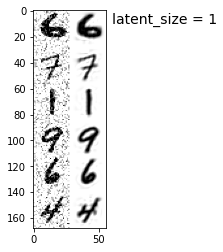

In [17]:
x = np.reshape(samples_noisy, (28*6,28 ,))
y = np.reshape(samples_decoded, (28*6,28 ,))
c = np.concatenate((x, y), axis=1)



plt.imshow(c, cmap='gray_r', clim=(0,1)) 
plt.text(60, 10, 'latent_size = '+str(1),
        rotation = 0,
        fontsize = 14)
plt.savefig("lol.png", format = "png")

In [18]:
# getDecoder and getEncoder methods are already valid

VAE_latent_size = 5

VAE_encoder = getEncoder(VAE_latent_size * 2)
VAE_decoder = getDecoder(VAE_latent_size)

VAE_input = Input(shape=(28, 28, 1)) # Set shape to (28, 28, 1) if autoencoder is convolutional, (784, 1) otherwise
VAE_encoder_output = VAE_encoder(VAE_input)
VAE_fake_generate, _ = tf.split(VAE_encoder_output, num_or_size_splits=2, axis=1)
VAE_fake_output = VAE_decoder(VAE_fake_generate)
fake_VAE = Model(inputs=VAE_input, outputs=VAE_fake_output)
fake_VAE.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 10)                96362     
_________________________________________________________________
tf_op_layer_split (TensorFlo [(None, 5), (None, 5)]    0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         111425    
Total params: 207,787
Trainable params: 207,787
Non-trainable params: 0
_________________________________________________________________


## Инструмент GradientTape
Преобразуем нашу выборку в датасет tensorflow. Нам потребуется рассчитывать потери - введём для этого функцию, просто считающую потери по mse, как ранее для автоэнкодера, без какой-то регуляризации.
Для ручного обучения в tensorflow есть инструмент GradientTape - лента записи событий, для которых можно просить выдать градиент по обучающимся параметрам. Он сам разбирается как такой градиент построить. Далее градиент уже передаётся оптимизатору. Тот сам разбирается как ему градиент применить для решения задачи оптимизации.

In [19]:
# x_train, y_train etc are already imported, normalized and expanded for convolutional NN

epochs = 10
train_size = len(x_train)
batch_size = 64
test_size = len(x_test)


train_dataset = (tf.data.Dataset.from_tensor_slices(x_train)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test)
                .shuffle(test_size).batch(batch_size))

def compute_loss(model, x):
  mse = tf.keras.losses.MeanSquaredError()
  return mse(model(x), x)

#@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [20]:
from PIL import Image

Epoch: 1, Test set loss: 0.05739085003733635, time elapse for current epoch: 54.9
Epoch: 2, Test set loss: 0.055261045694351196, time elapse for current epoch: 54.2
Epoch: 3, Test set loss: 0.05395442992448807, time elapse for current epoch: 54.3
Epoch: 4, Test set loss: 0.05383668094873428, time elapse for current epoch: 55.7
Epoch: 5, Test set loss: 0.05314087122678757, time elapse for current epoch: 54.1
Epoch: 6, Test set loss: 0.052223458886146545, time elapse for current epoch: 54.5
Epoch: 7, Test set loss: 0.05213586241006851, time elapse for current epoch: 54.1
Epoch: 8, Test set loss: 0.052641648799180984, time elapse for current epoch: 54.3
Epoch: 9, Test set loss: 0.0520133413374424, time elapse for current epoch: 55.4
Epoch: 10, Test set loss: 0.05250540375709534, time elapse for current epoch: 53.2


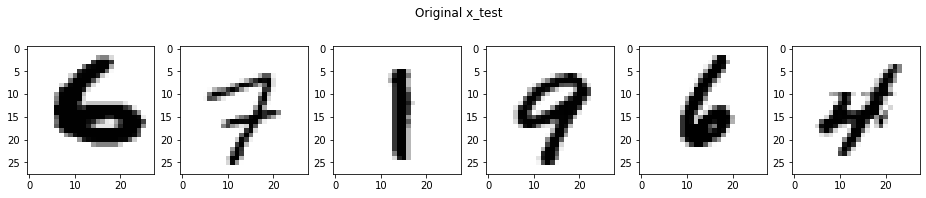

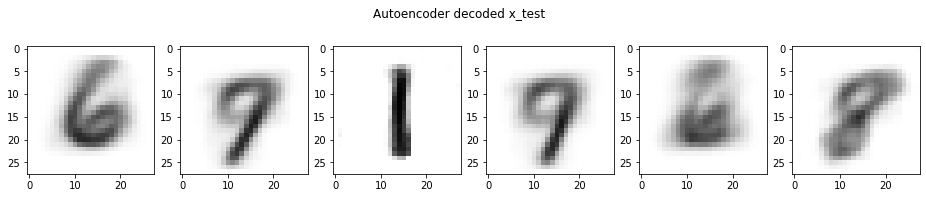

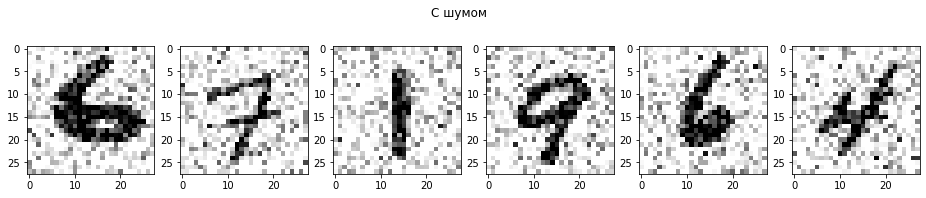

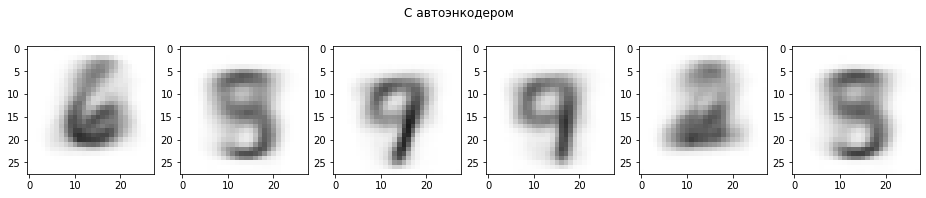

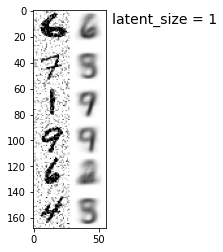

Images.shape 1
Epoch: 1, Test set loss: 0.011637251824140549, time elapse for current epoch: 54.1
Epoch: 2, Test set loss: 0.009368184953927994, time elapse for current epoch: 54.2
Epoch: 3, Test set loss: 0.00810711458325386, time elapse for current epoch: 54.3
Epoch: 4, Test set loss: 0.007631363347172737, time elapse for current epoch: 54.7
Epoch: 5, Test set loss: 0.007309301756322384, time elapse for current epoch: 55.5
Epoch: 6, Test set loss: 0.006951341405510902, time elapse for current epoch: 54.1
Epoch: 7, Test set loss: 0.006723479833453894, time elapse for current epoch: 54.7
Epoch: 8, Test set loss: 0.006640804000198841, time elapse for current epoch: 54.4
Epoch: 9, Test set loss: 0.006624980363994837, time elapse for current epoch: 54.2
Epoch: 10, Test set loss: 0.006276238709688187, time elapse for current epoch: 54.8


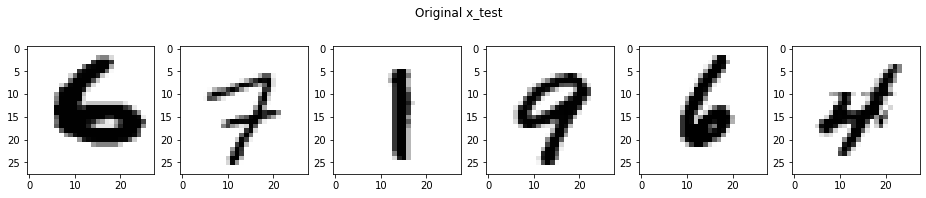

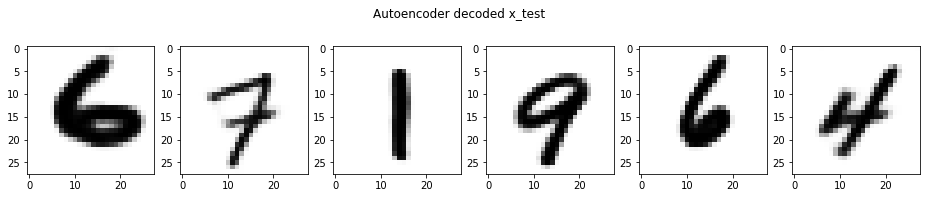

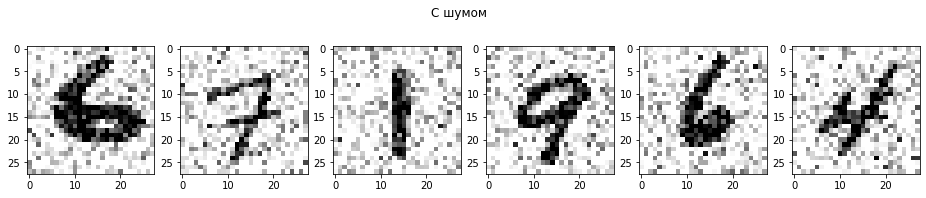

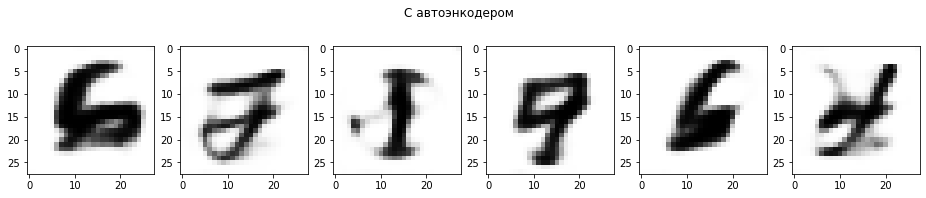

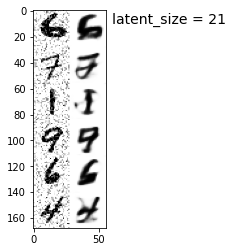

Images.shape 2
Epoch: 1, Test set loss: 0.00812565628439188, time elapse for current epoch: 53.4
Epoch: 2, Test set loss: 0.0056774732656776905, time elapse for current epoch: 54.1
Epoch: 3, Test set loss: 0.005066908895969391, time elapse for current epoch: 53.6
Epoch: 4, Test set loss: 0.004278525244444609, time elapse for current epoch: 53.9
Epoch: 5, Test set loss: 0.004070723429322243, time elapse for current epoch: 54.5
Epoch: 6, Test set loss: 0.0038276321720331907, time elapse for current epoch: 56.3
Epoch: 7, Test set loss: 0.0036599324084818363, time elapse for current epoch: 54.8
Epoch: 8, Test set loss: 0.0035124325659126043, time elapse for current epoch: 55.6
Epoch: 9, Test set loss: 0.0032802110072225332, time elapse for current epoch: 55.4
Epoch: 10, Test set loss: 0.003309718333184719, time elapse for current epoch: 55.3


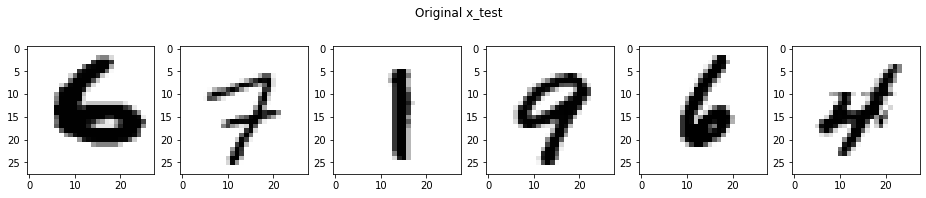

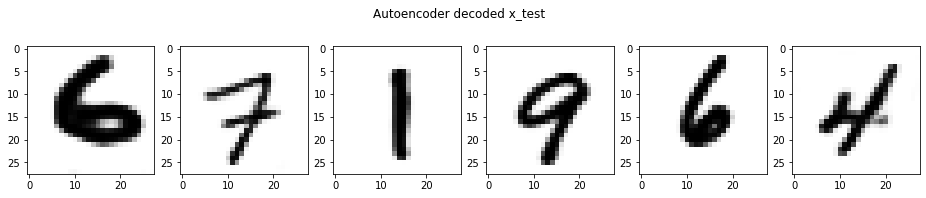

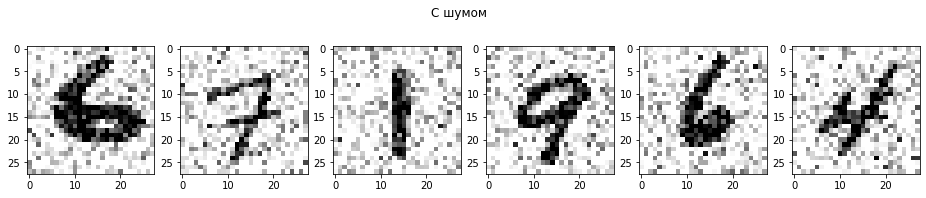

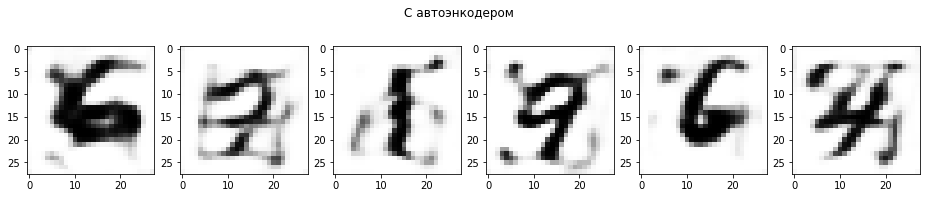

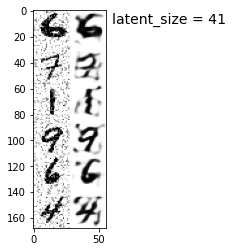

Images.shape 3
Epoch: 1, Test set loss: 0.007848139852285385, time elapse for current epoch: 56.9
Epoch: 2, Test set loss: 0.005075131077319384, time elapse for current epoch: 55.2
Epoch: 3, Test set loss: 0.0041162301786243916, time elapse for current epoch: 55.3
Epoch: 4, Test set loss: 0.003594860201701522, time elapse for current epoch: 55.3
Epoch: 5, Test set loss: 0.0032746437937021255, time elapse for current epoch: 55.2
Epoch: 6, Test set loss: 0.0030255033634603024, time elapse for current epoch: 54.5
Epoch: 7, Test set loss: 0.002931719645857811, time elapse for current epoch: 55.7
Epoch: 8, Test set loss: 0.0026976356748491526, time elapse for current epoch: 55.2
Epoch: 9, Test set loss: 0.0027261818759143353, time elapse for current epoch: 55.4
Epoch: 10, Test set loss: 0.002540979301556945, time elapse for current epoch: 55.0


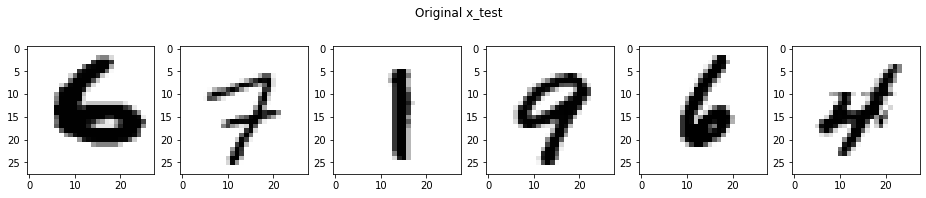

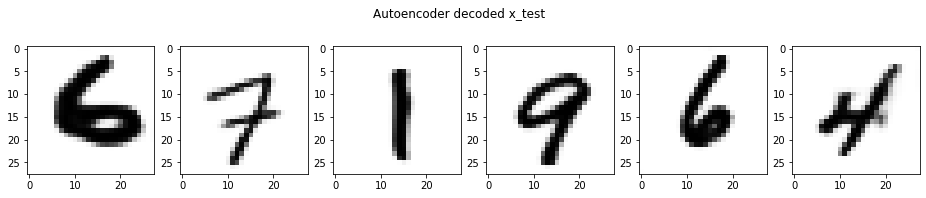

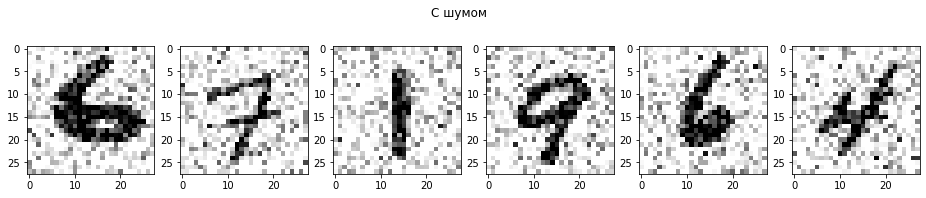

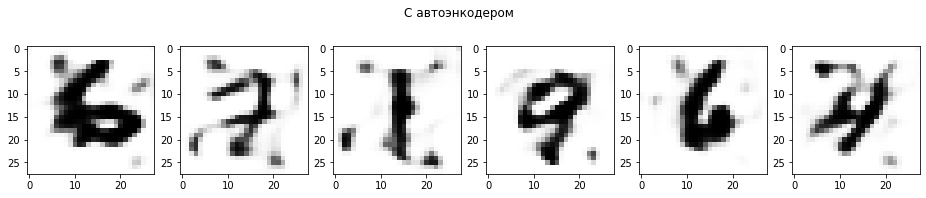

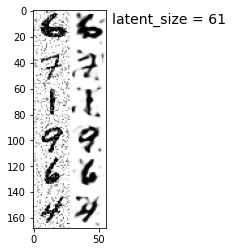

Images.shape 4
Epoch: 1, Test set loss: 0.007513449527323246, time elapse for current epoch: 55.6
Epoch: 2, Test set loss: 0.004946398548781872, time elapse for current epoch: 56.5
Epoch: 3, Test set loss: 0.003995779436081648, time elapse for current epoch: 55.1
Epoch: 4, Test set loss: 0.0035053533501923084, time elapse for current epoch: 55.7
Epoch: 5, Test set loss: 0.0030958792194724083, time elapse for current epoch: 55.1
Epoch: 6, Test set loss: 0.0029148010071367025, time elapse for current epoch: 54.5
Epoch: 7, Test set loss: 0.002631912473589182, time elapse for current epoch: 53.5
Epoch: 8, Test set loss: 0.0026233396492898464, time elapse for current epoch: 55.1
Epoch: 9, Test set loss: 0.0024862256832420826, time elapse for current epoch: 53.6
Epoch: 10, Test set loss: 0.0024380446411669254, time elapse for current epoch: 53.0


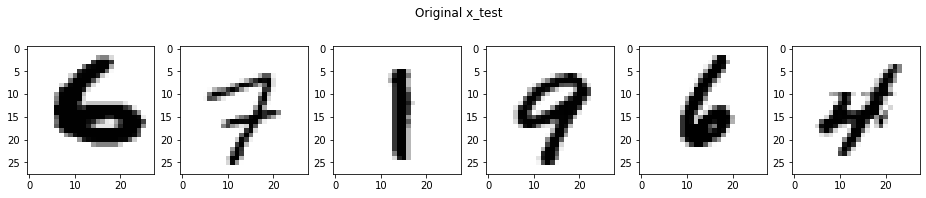

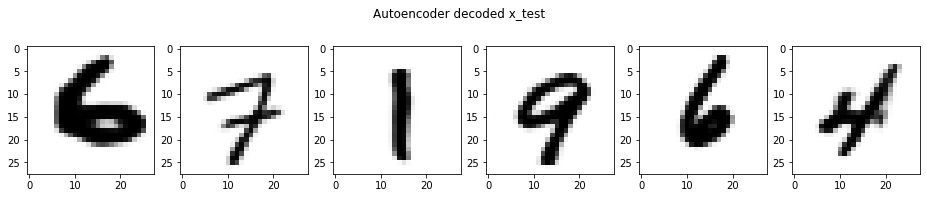

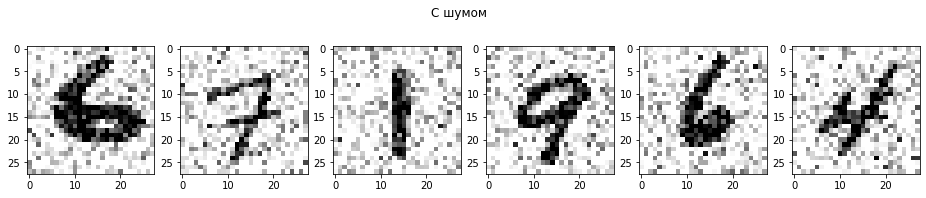

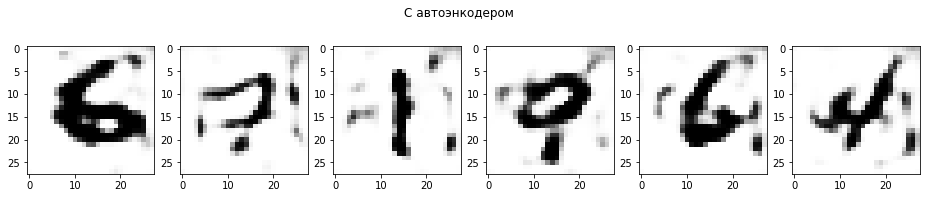

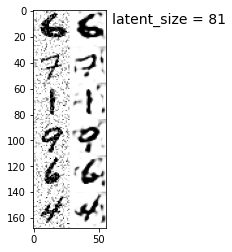

Images.shape 5
Epoch: 1, Test set loss: 0.006765858270227909, time elapse for current epoch: 54.3
Epoch: 2, Test set loss: 0.0045759654603898525, time elapse for current epoch: 53.9
Epoch: 3, Test set loss: 0.0038717309944331646, time elapse for current epoch: 54.9
Epoch: 4, Test set loss: 0.0034803084563463926, time elapse for current epoch: 53.8
Epoch: 5, Test set loss: 0.003111252561211586, time elapse for current epoch: 54.2
Epoch: 6, Test set loss: 0.002701587975025177, time elapse for current epoch: 53.8
Epoch: 7, Test set loss: 0.002610986353829503, time elapse for current epoch: 53.8
Epoch: 8, Test set loss: 0.002500080270692706, time elapse for current epoch: 54.2
Epoch: 9, Test set loss: 0.0023371605202555656, time elapse for current epoch: 54.9
Epoch: 10, Test set loss: 0.0023210160434246063, time elapse for current epoch: 55.7


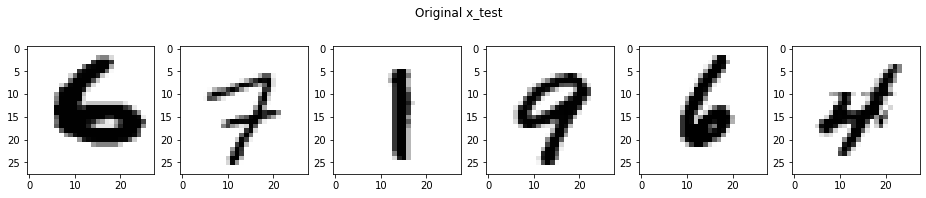

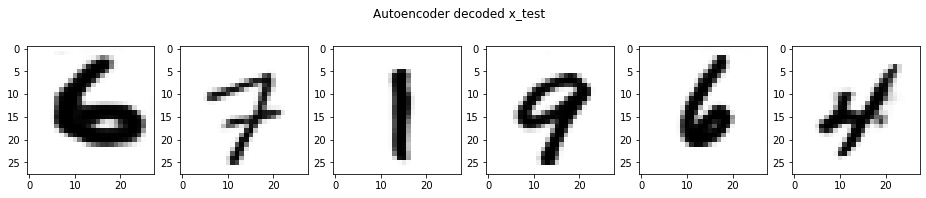

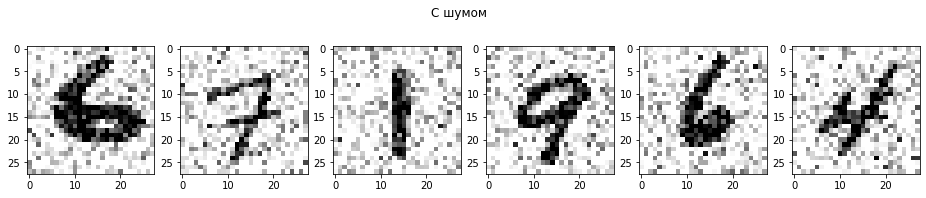

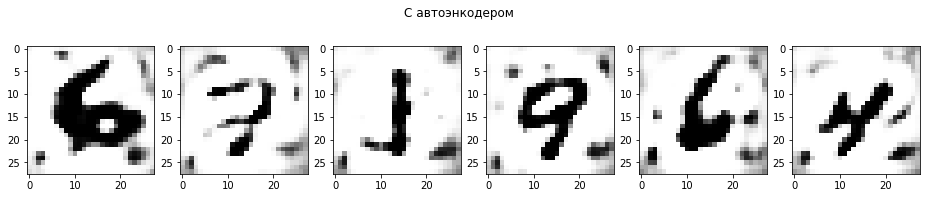

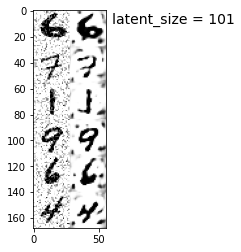

Images.shape 6
Epoch: 1, Test set loss: 0.006940406747162342, time elapse for current epoch: 55.0
Epoch: 2, Test set loss: 0.004810246638953686, time elapse for current epoch: 54.1
Epoch: 3, Test set loss: 0.0038158653769642115, time elapse for current epoch: 54.2
Epoch: 4, Test set loss: 0.0030587115325033665, time elapse for current epoch: 56.4
Epoch: 5, Test set loss: 0.0029117674566805363, time elapse for current epoch: 55.0
Epoch: 6, Test set loss: 0.002697385149076581, time elapse for current epoch: 55.2
Epoch: 7, Test set loss: 0.0024579972960054874, time elapse for current epoch: 55.1
Epoch: 8, Test set loss: 0.002436439972370863, time elapse for current epoch: 55.2
Epoch: 9, Test set loss: 0.002328204922378063, time elapse for current epoch: 54.6
Epoch: 10, Test set loss: 0.002127057407051325, time elapse for current epoch: 56.2


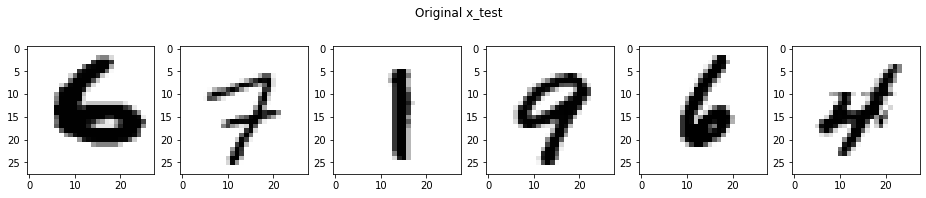

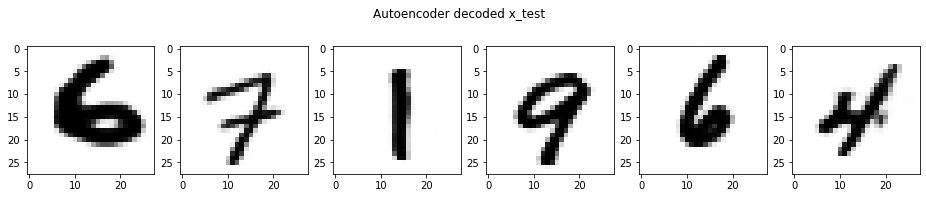

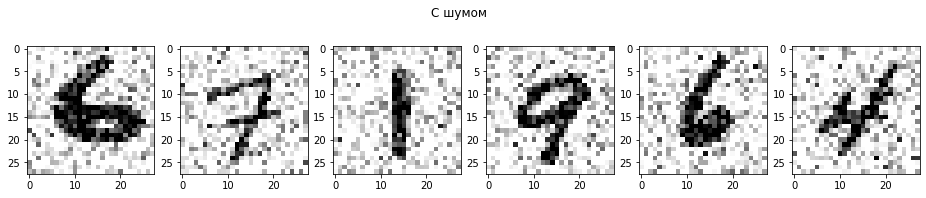

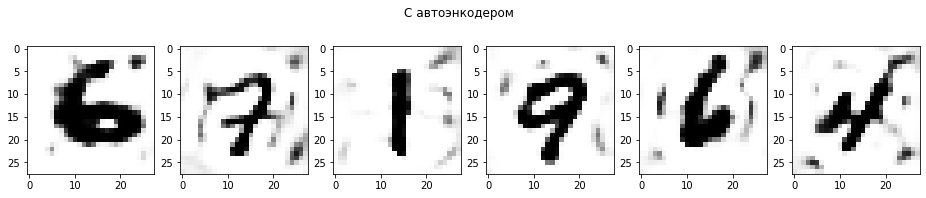

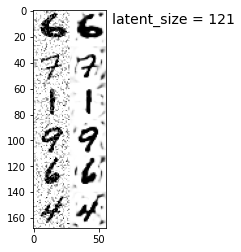

Images.shape 7
Epoch: 1, Test set loss: 0.0068967510014772415, time elapse for current epoch: 55.6
Epoch: 2, Test set loss: 0.0046118879690766335, time elapse for current epoch: 55.3
Epoch: 3, Test set loss: 0.003637454705312848, time elapse for current epoch: 54.8
Epoch: 4, Test set loss: 0.003177720820531249, time elapse for current epoch: 55.1
Epoch: 5, Test set loss: 0.0028852527029812336, time elapse for current epoch: 55.5
Epoch: 6, Test set loss: 0.002643203129991889, time elapse for current epoch: 54.3
Epoch: 7, Test set loss: 0.002477881731465459, time elapse for current epoch: 55.0
Epoch: 8, Test set loss: 0.002300168387591839, time elapse for current epoch: 55.1
Epoch: 9, Test set loss: 0.002192496554926038, time elapse for current epoch: 53.5
Epoch: 10, Test set loss: 0.0021296869963407516, time elapse for current epoch: 53.2


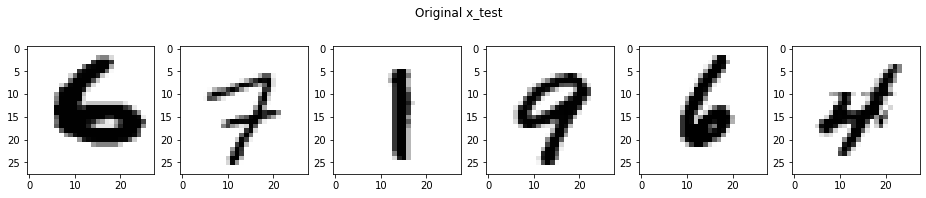

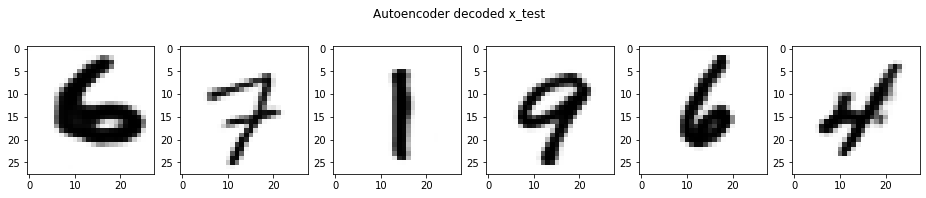

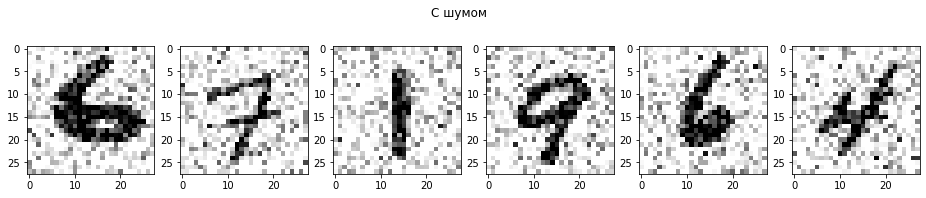

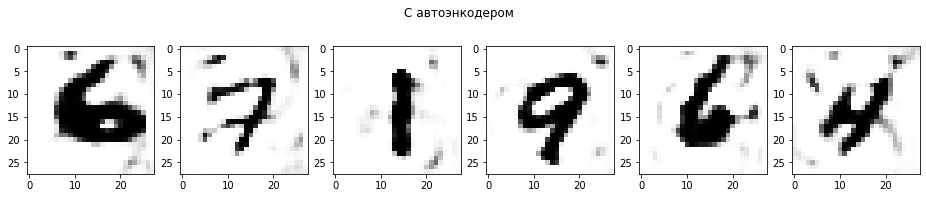

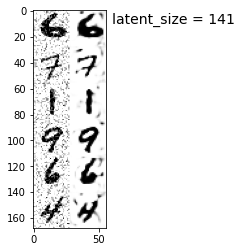

Images.shape 8
Epoch: 1, Test set loss: 0.0067327506840229034, time elapse for current epoch: 54.9
Epoch: 2, Test set loss: 0.004525167401880026, time elapse for current epoch: 54.2
Epoch: 3, Test set loss: 0.0038110772147774696, time elapse for current epoch: 53.3
Epoch: 4, Test set loss: 0.003281306242570281, time elapse for current epoch: 53.4
Epoch: 5, Test set loss: 0.002733494620770216, time elapse for current epoch: 53.5
Epoch: 6, Test set loss: 0.0025243584532290697, time elapse for current epoch: 53.9
Epoch: 7, Test set loss: 0.0025033068377524614, time elapse for current epoch: 54.0
Epoch: 8, Test set loss: 0.0023251574020832777, time elapse for current epoch: 52.9
Epoch: 9, Test set loss: 0.002202141098678112, time elapse for current epoch: 53.0
Epoch: 10, Test set loss: 0.0021108088549226522, time elapse for current epoch: 53.1


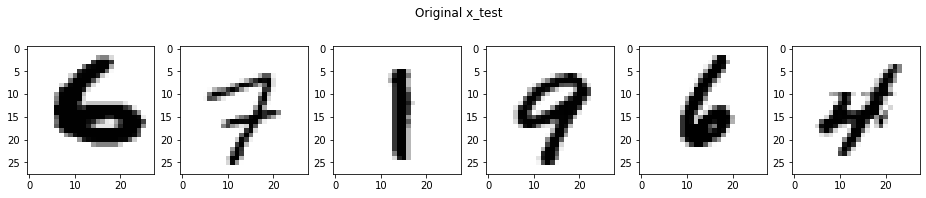

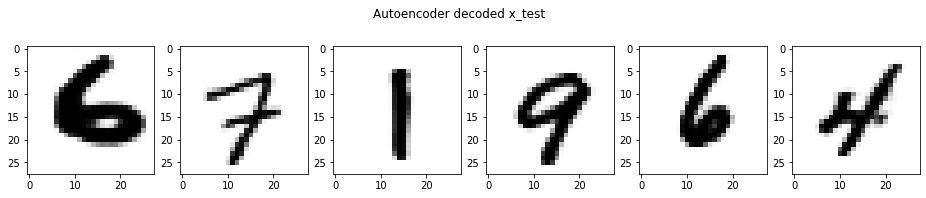

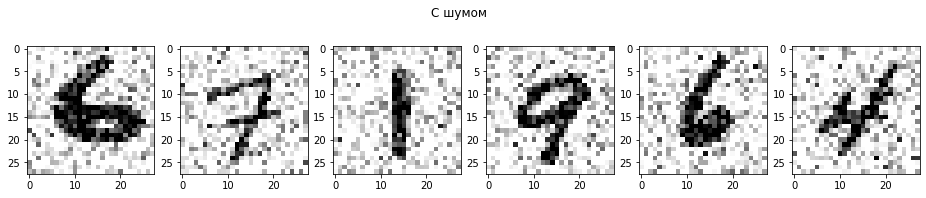

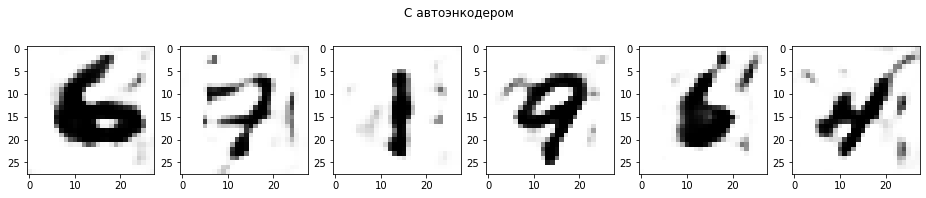

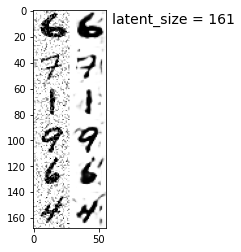

Images.shape 9
Epoch: 1, Test set loss: 0.006469349842518568, time elapse for current epoch: 53.3
Epoch: 2, Test set loss: 0.004434122703969479, time elapse for current epoch: 54.2
Epoch: 3, Test set loss: 0.003532904665917158, time elapse for current epoch: 53.4
Epoch: 4, Test set loss: 0.0032588979229331017, time elapse for current epoch: 53.1
Epoch: 5, Test set loss: 0.00281796557828784, time elapse for current epoch: 52.9
Epoch: 6, Test set loss: 0.0026299147866666317, time elapse for current epoch: 53.2
Epoch: 7, Test set loss: 0.0023670559749007225, time elapse for current epoch: 53.1
Epoch: 8, Test set loss: 0.0022943122312426567, time elapse for current epoch: 54.2
Epoch: 9, Test set loss: 0.002182738156989217, time elapse for current epoch: 53.3
Epoch: 10, Test set loss: 0.00206400896422565, time elapse for current epoch: 52.2


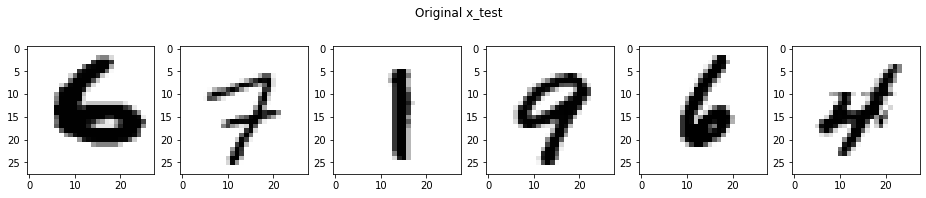

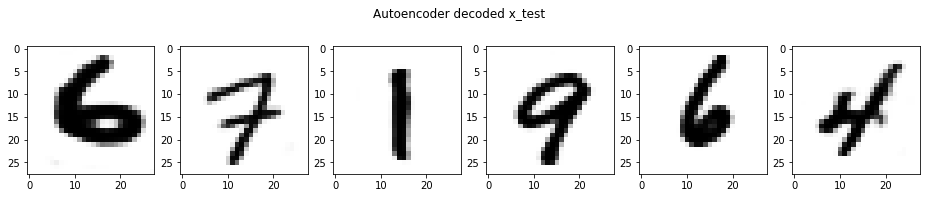

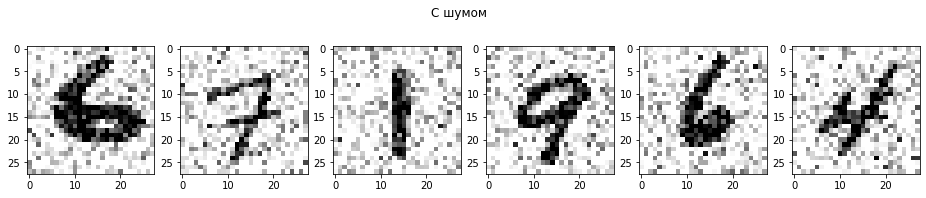

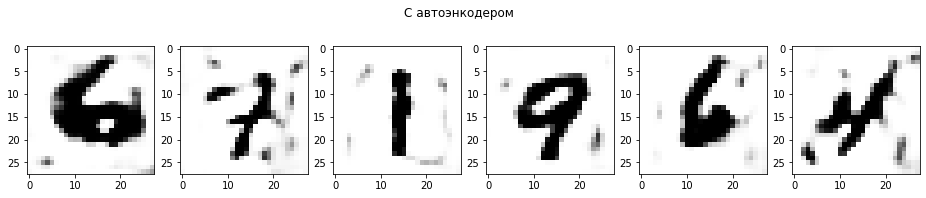

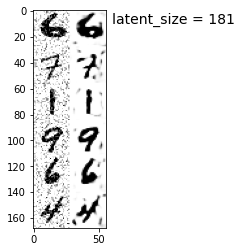

Images.shape 10
Epoch: 1, Test set loss: 0.006227345205843449, time elapse for current epoch: 53.3
Epoch: 2, Test set loss: 0.004491090774536133, time elapse for current epoch: 53.4
Epoch: 3, Test set loss: 0.003686868119984865, time elapse for current epoch: 53.7
Epoch: 4, Test set loss: 0.003066042438149452, time elapse for current epoch: 54.3
Epoch: 5, Test set loss: 0.002728235675022006, time elapse for current epoch: 53.0
Epoch: 6, Test set loss: 0.002488097408786416, time elapse for current epoch: 53.4
Epoch: 7, Test set loss: 0.002391594694927335, time elapse for current epoch: 53.3
Epoch: 8, Test set loss: 0.00227324734441936, time elapse for current epoch: 53.3
Epoch: 9, Test set loss: 0.0022020491305738688, time elapse for current epoch: 54.7
Epoch: 10, Test set loss: 0.00203194422647357, time elapse for current epoch: 53.8


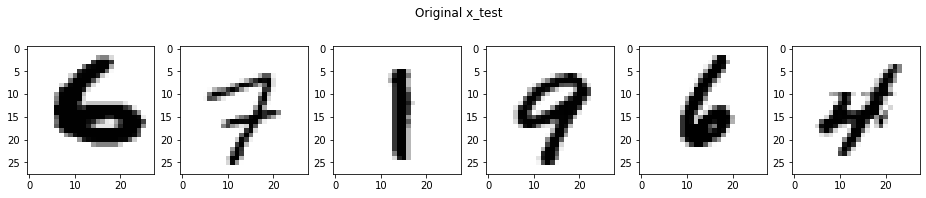

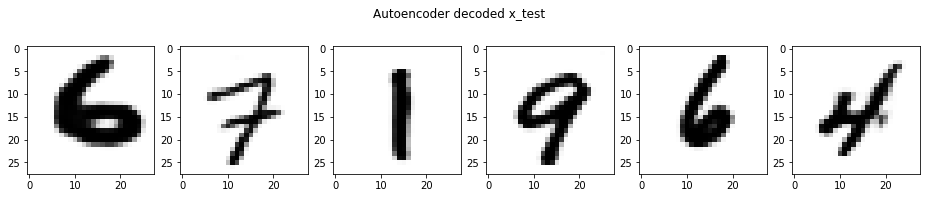

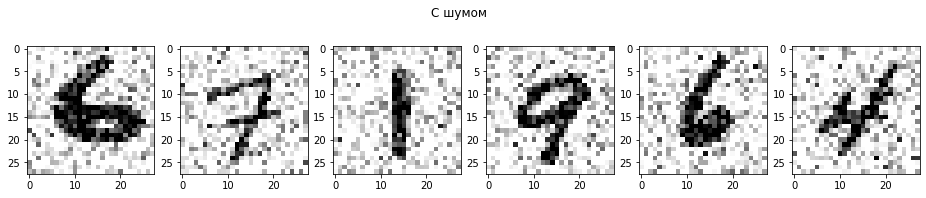

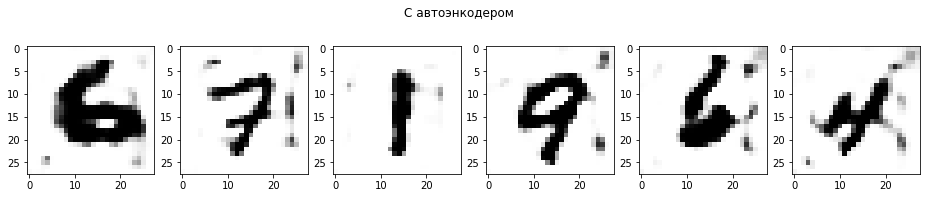

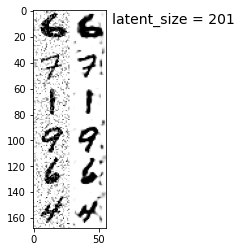

Images.shape 11
Epoch: 1, Test set loss: 0.006336189806461334, time elapse for current epoch: 53.1
Epoch: 2, Test set loss: 0.004466124344617128, time elapse for current epoch: 53.3
Epoch: 3, Test set loss: 0.003688524477183819, time elapse for current epoch: 52.7
Epoch: 4, Test set loss: 0.003260871395468712, time elapse for current epoch: 52.2
Epoch: 5, Test set loss: 0.0027883804868906736, time elapse for current epoch: 54.7
Epoch: 6, Test set loss: 0.0025790994986891747, time elapse for current epoch: 53.1
Epoch: 7, Test set loss: 0.002411200199276209, time elapse for current epoch: 52.8
Epoch: 8, Test set loss: 0.0022756452672183514, time elapse for current epoch: 53.1
Epoch: 9, Test set loss: 0.0022122119553387165, time elapse for current epoch: 53.2
Epoch: 10, Test set loss: 0.002097735181450844, time elapse for current epoch: 53.7


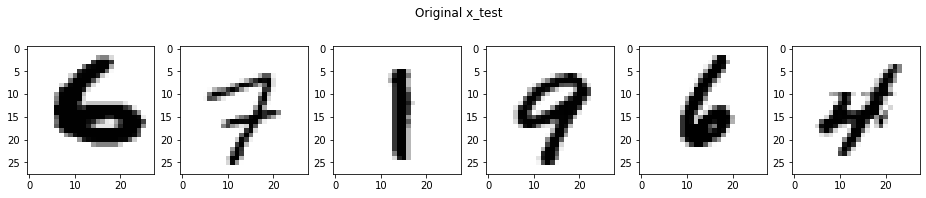

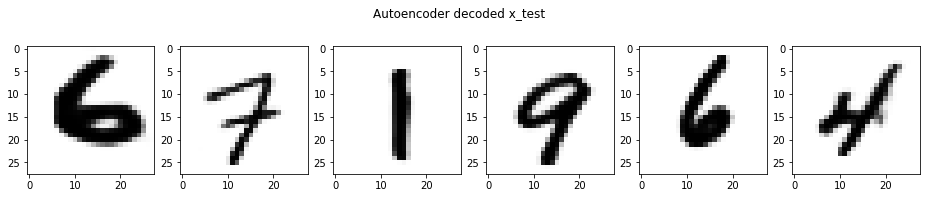

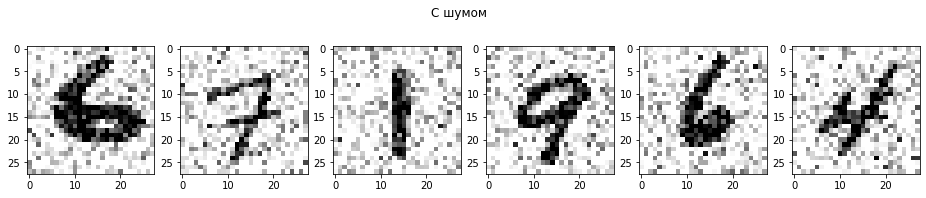

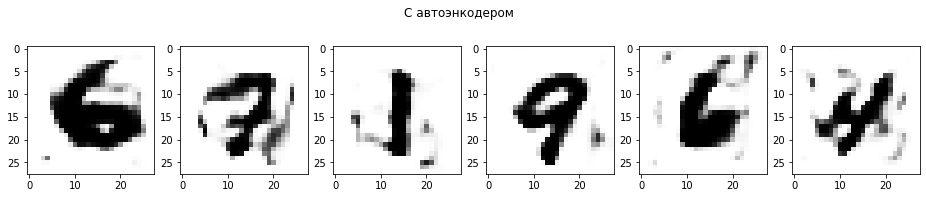

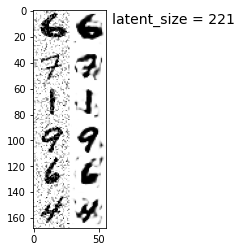

Images.shape 12
Epoch: 1, Test set loss: 0.0065904948860406876, time elapse for current epoch: 54.4
Epoch: 2, Test set loss: 0.004182119388133287, time elapse for current epoch: 53.6
Epoch: 3, Test set loss: 0.0037020270247012377, time elapse for current epoch: 53.3
Epoch: 4, Test set loss: 0.0030306275002658367, time elapse for current epoch: 53.4
Epoch: 5, Test set loss: 0.002748522674664855, time elapse for current epoch: 53.6
Epoch: 6, Test set loss: 0.002508817706257105, time elapse for current epoch: 55.0
Epoch: 7, Test set loss: 0.0024121685419231653, time elapse for current epoch: 52.2
Epoch: 8, Test set loss: 0.0021834184881299734, time elapse for current epoch: 53.4
Epoch: 9, Test set loss: 0.0021413222420960665, time elapse for current epoch: 53.7
Epoch: 10, Test set loss: 0.0019802949391305447, time elapse for current epoch: 53.3


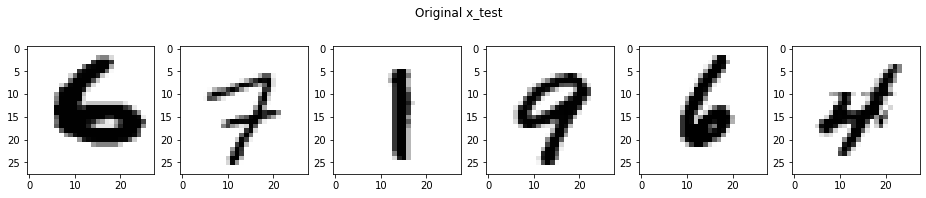

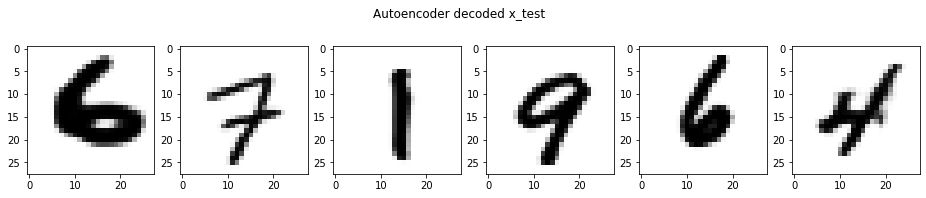

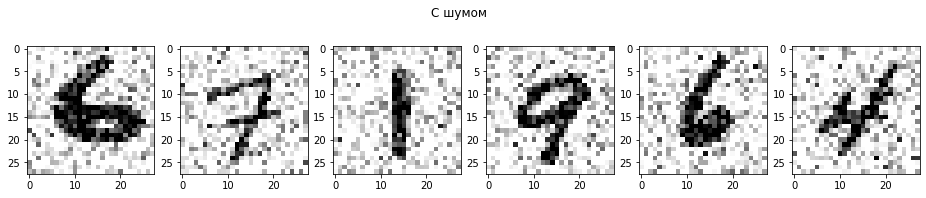

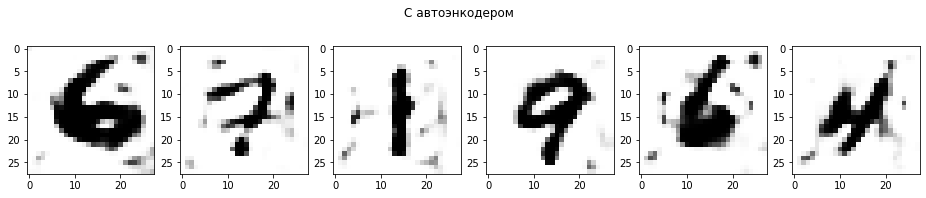

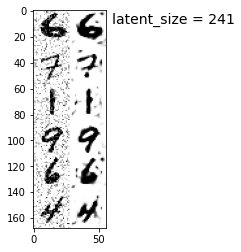

Images.shape 13
Epoch: 1, Test set loss: 0.006747502367943525, time elapse for current epoch: 53.7
Epoch: 2, Test set loss: 0.0044167060405015945, time elapse for current epoch: 55.3
Epoch: 3, Test set loss: 0.003708183765411377, time elapse for current epoch: 53.4
Epoch: 4, Test set loss: 0.0030381365213543177, time elapse for current epoch: 53.6
Epoch: 5, Test set loss: 0.002790244994685054, time elapse for current epoch: 53.7
Epoch: 6, Test set loss: 0.0025377091951668262, time elapse for current epoch: 53.5
Epoch: 7, Test set loss: 0.0023326536174863577, time elapse for current epoch: 55.1
Epoch: 8, Test set loss: 0.0022774706594645977, time elapse for current epoch: 53.7
Epoch: 9, Test set loss: 0.002065290929749608, time elapse for current epoch: 53.4
Epoch: 10, Test set loss: 0.002100218553096056, time elapse for current epoch: 52.7


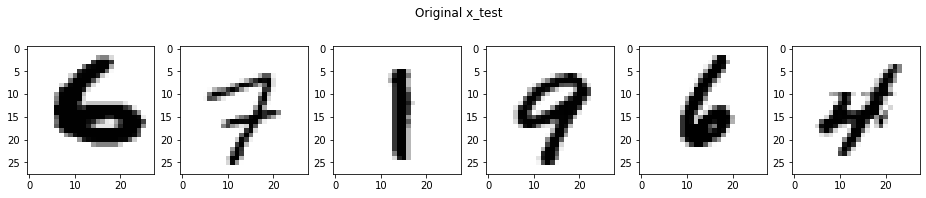

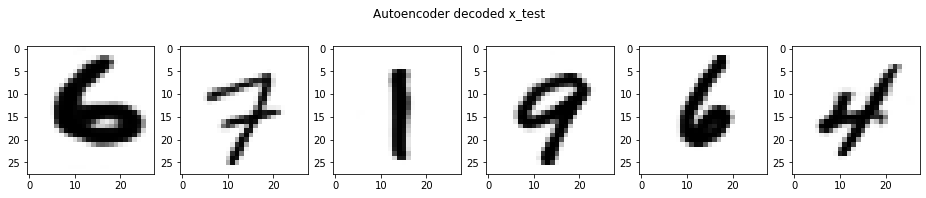

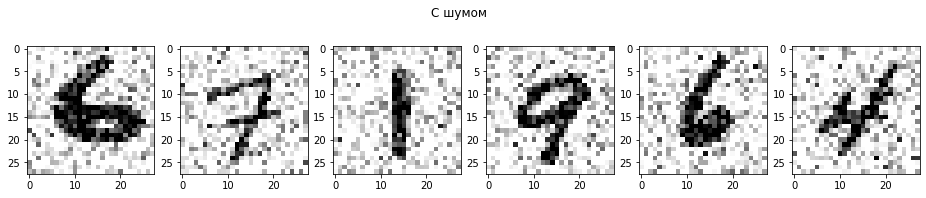

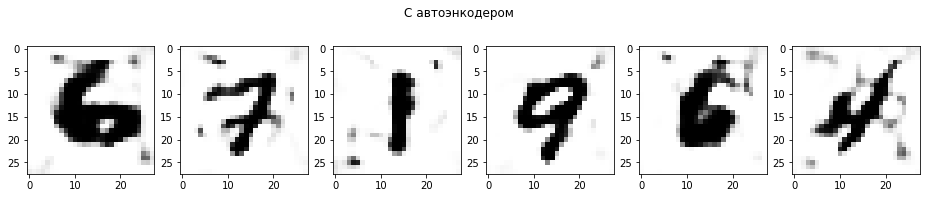

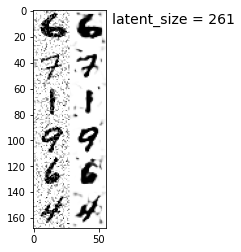

Images.shape 14
Epoch: 1, Test set loss: 0.006374464835971594, time elapse for current epoch: 53.3
Epoch: 2, Test set loss: 0.004298453219234943, time elapse for current epoch: 53.2
Epoch: 3, Test set loss: 0.0034228358417749405, time elapse for current epoch: 55.1
Epoch: 4, Test set loss: 0.0030054859817028046, time elapse for current epoch: 53.8
Epoch: 5, Test set loss: 0.0025998754426836967, time elapse for current epoch: 53.6
Epoch: 6, Test set loss: 0.002409433014690876, time elapse for current epoch: 53.3
Epoch: 7, Test set loss: 0.002227611606940627, time elapse for current epoch: 53.6
Epoch: 8, Test set loss: 0.0021639566402882338, time elapse for current epoch: 53.8
Epoch: 9, Test set loss: 0.0021391496993601322, time elapse for current epoch: 54.8
Epoch: 10, Test set loss: 0.002005307236686349, time elapse for current epoch: 53.7


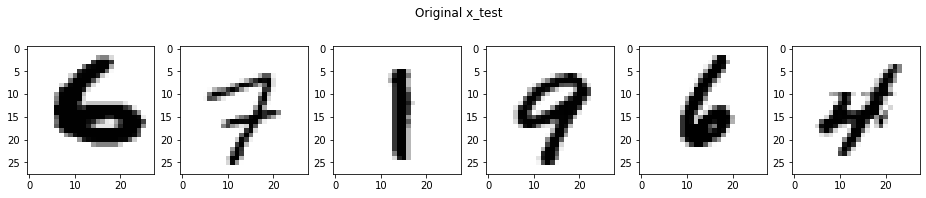

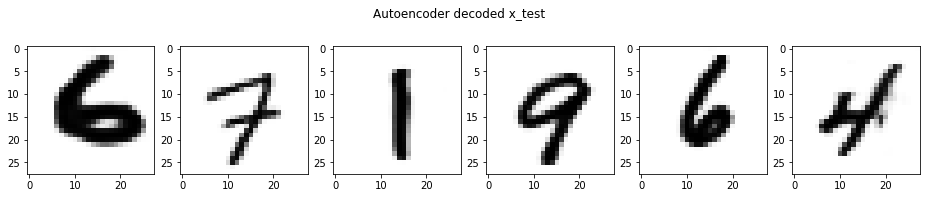

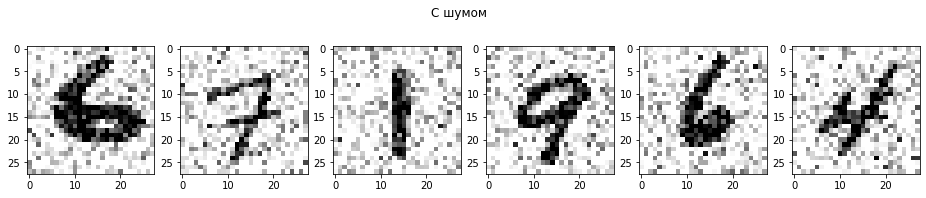

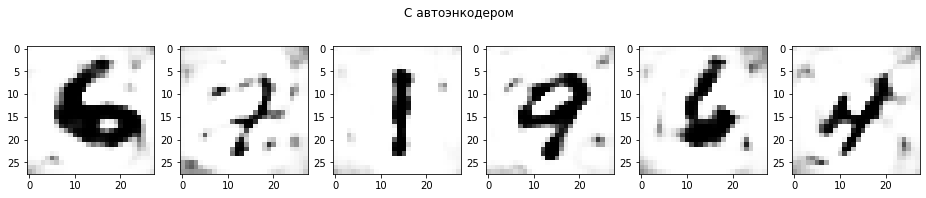

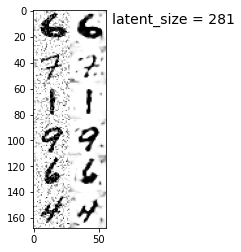

Images.shape 15
Epoch: 1, Test set loss: 0.005990895442664623, time elapse for current epoch: 53.9
Epoch: 2, Test set loss: 0.004415301140397787, time elapse for current epoch: 53.4
Epoch: 3, Test set loss: 0.0035401443019509315, time elapse for current epoch: 52.8
Epoch: 4, Test set loss: 0.0030703581869602203, time elapse for current epoch: 54.9
Epoch: 5, Test set loss: 0.0027679558843374252, time elapse for current epoch: 53.5
Epoch: 6, Test set loss: 0.002500187372788787, time elapse for current epoch: 53.6
Epoch: 7, Test set loss: 0.00230652978643775, time elapse for current epoch: 53.6
Epoch: 8, Test set loss: 0.0022452333942055702, time elapse for current epoch: 53.6
Epoch: 9, Test set loss: 0.002148582600057125, time elapse for current epoch: 53.7
Epoch: 10, Test set loss: 0.0019798963330686092, time elapse for current epoch: 55.3


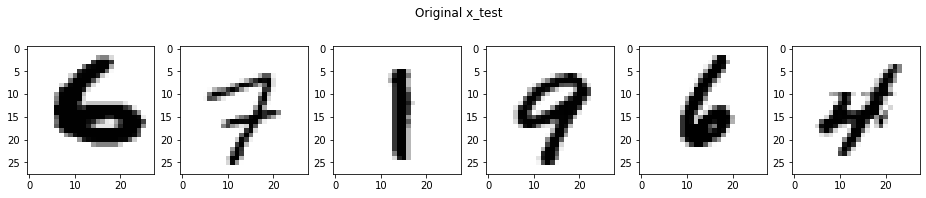

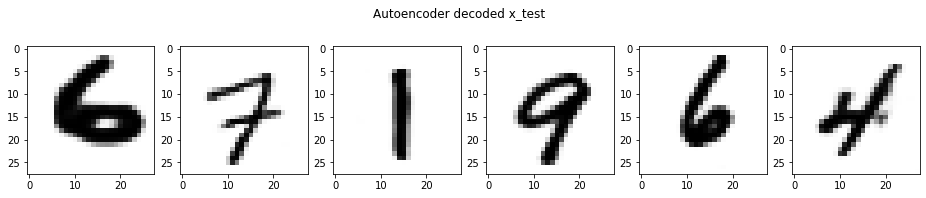

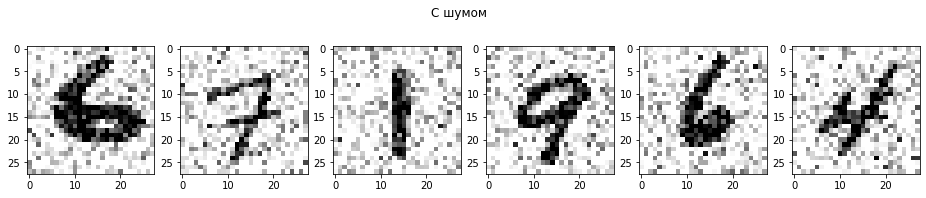

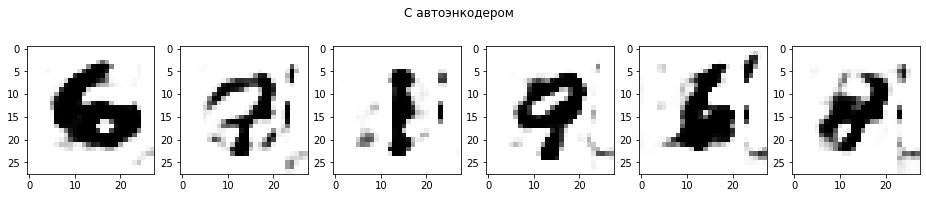

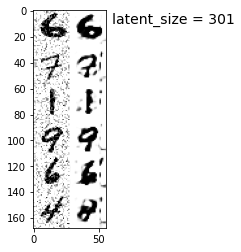

Images.shape 16
Epoch: 1, Test set loss: 0.006186116486787796, time elapse for current epoch: 53.4
Epoch: 2, Test set loss: 0.004325217567384243, time elapse for current epoch: 52.7
Epoch: 3, Test set loss: 0.003552664304152131, time elapse for current epoch: 52.7
Epoch: 4, Test set loss: 0.002883246634155512, time elapse for current epoch: 53.3
Epoch: 5, Test set loss: 0.00268883490934968, time elapse for current epoch: 54.1
Epoch: 6, Test set loss: 0.0025820236187428236, time elapse for current epoch: 53.7
Epoch: 7, Test set loss: 0.0023791987914592028, time elapse for current epoch: 53.6
Epoch: 8, Test set loss: 0.0021860855631530285, time elapse for current epoch: 53.9
Epoch: 9, Test set loss: 0.0020481604151427746, time elapse for current epoch: 53.5
Epoch: 10, Test set loss: 0.0020142337307333946, time elapse for current epoch: 53.7


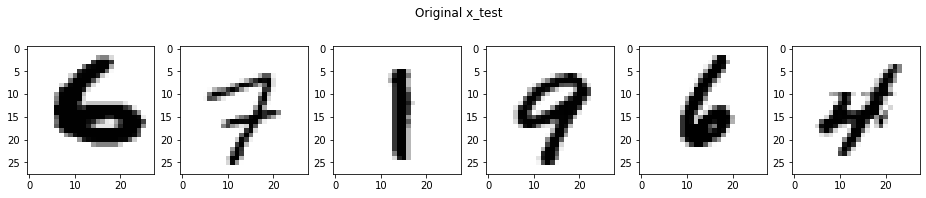

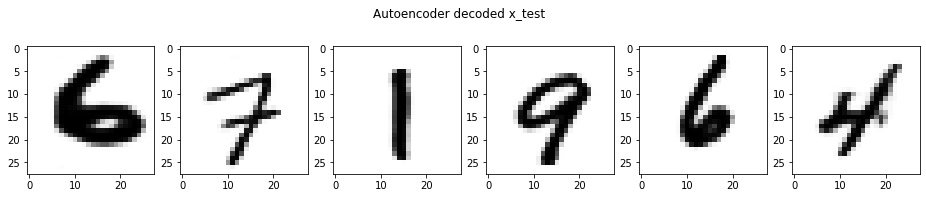

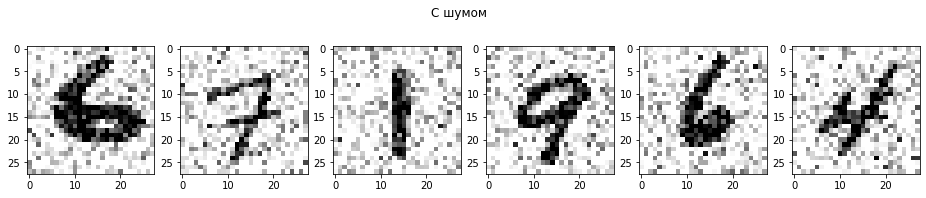

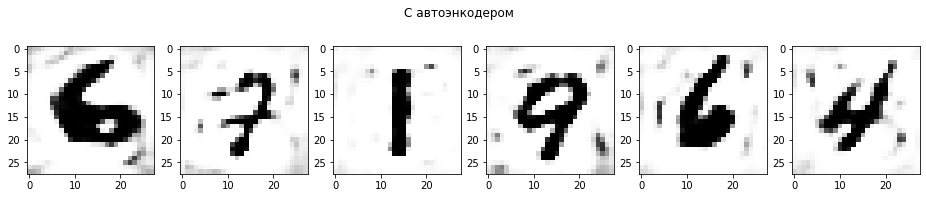

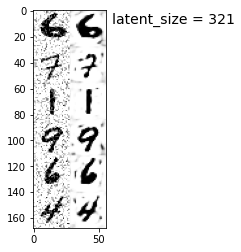

Images.shape 17
Epoch: 1, Test set loss: 0.005959401838481426, time elapse for current epoch: 55.5
Epoch: 2, Test set loss: 0.004203598480671644, time elapse for current epoch: 53.7
Epoch: 3, Test set loss: 0.0034950580447912216, time elapse for current epoch: 53.5
Epoch: 4, Test set loss: 0.00296895788051188, time elapse for current epoch: 52.6
Epoch: 5, Test set loss: 0.0026904535479843616, time elapse for current epoch: 51.9
Epoch: 6, Test set loss: 0.002388295251876116, time elapse for current epoch: 52.7
Epoch: 7, Test set loss: 0.0023993649519979954, time elapse for current epoch: 53.4
Epoch: 8, Test set loss: 0.0021914655808359385, time elapse for current epoch: 52.4
Epoch: 9, Test set loss: 0.002068196190521121, time elapse for current epoch: 53.4
Epoch: 10, Test set loss: 0.0020540279801934958, time elapse for current epoch: 52.9


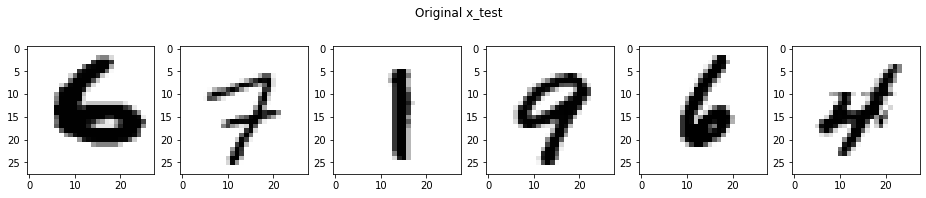

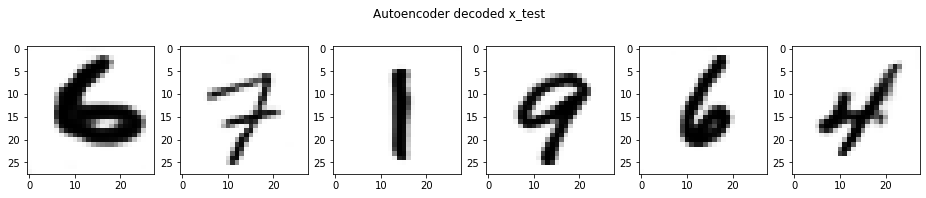

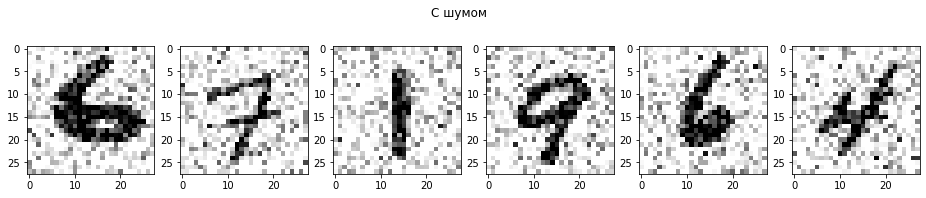

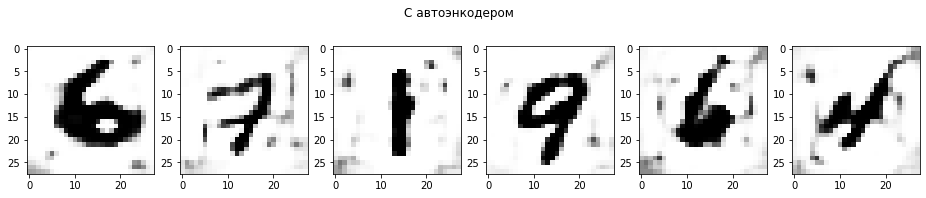

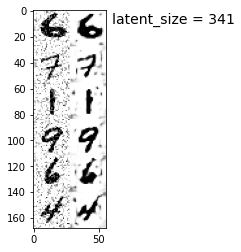

Images.shape 18
Epoch: 1, Test set loss: 0.006386558059602976, time elapse for current epoch: 53.3
Epoch: 2, Test set loss: 0.004255553707480431, time elapse for current epoch: 54.4


In [ ]:

images = []
for i in range(1, 784, 20
               ):

    VAE_latent_size = i
    VAE_encoder = getEncoder(VAE_latent_size * 2)
    VAE_decoder = getDecoder(VAE_latent_size)

    VAE_input = Input(shape=(28, 28, 1)) # Set shape to (28, 28, 1) if autoencoder is convolutional, (784, 1) otherwise
    VAE_encoder_output = VAE_encoder(VAE_input)
    VAE_fake_generate, _ = tf.split(VAE_encoder_output, num_or_size_splits=2, axis=1)
    VAE_fake_output = VAE_decoder(VAE_fake_generate)
    fake_VAE = Model(inputs=VAE_input, outputs=VAE_fake_output)

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_x in train_dataset:
            train_step(fake_VAE, train_x, tf.keras.optimizers.Adam(learning_rate=0.001))
        end_time = time.time()

        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(fake_VAE, test_x))
        print('Epoch: {}, Test set loss: {}, time elapse for current epoch: {:.3}'
            .format(epoch, loss.result(), end_time - start_time))
    samples_decoded = np.squeeze(fake_VAE.predict(samples_orig), axis = 3)
    plot_images(samples_orig, "Original x_test")
    plot_images(samples_decoded, "Autoencoder decoded x_test")
    samples_decoded = np.squeeze(fake_VAE.predict(samples_noisy), axis = 3)
    plot_images(samples_noisy, "С шумом")
    plot_images(samples_decoded, "С автоэнкодером")
    
    x = np.reshape(samples_noisy, (28*6,28 ,))
    y = np.reshape(samples_decoded, (28*6,28 ,))
    c = np.concatenate((x, y), axis=1)

    plt.imshow(c, cmap='gray_r', clim=(0,1)) 
    plt.text(60, 10, 'latent_size = '+str(i), rotation = 0, fontsize = 14)
    plt.savefig("lol.png", format = "png")
    plt.show() 
    image = Image.open("lol.png")
    ar = np.asarray(image)
    images.append(ar)
    print("Images.shape",len(images))

Мы импортируем модель расчёта времени, чтобы знать сколько длится эпоха. Эпохи это реализуемый вручную цикл вызова расчёта потерь, градиента, оптимизации. В цикле мы будем брать батч за батчем, считать время на эпоху, дополнительно для проверки обучения будем считать потери на всех батчах тестовой выборки и выводить статистику.

In [1]:
kargs = { 'duration': 3 }
for i in range(10):

    print(images[i])
imageio.mimsave('gan_learning.gif', images, None, **kargs)

NameError: ignored

(140, 28)


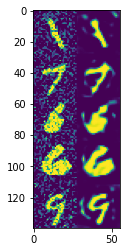

In [51]:
samples_noisy.shape
x = np.reshape(samples_noisy, (28*5,28 ,))
y = np.reshape(np.squeeze(fake_VAE.predict(samples_noisy), axis = 3), (28*5,28 ,))
print(x.shape)
c = np.concatenate((x, y), axis=1)
plt.imshow(c, clim=(0,1))
plt.show()

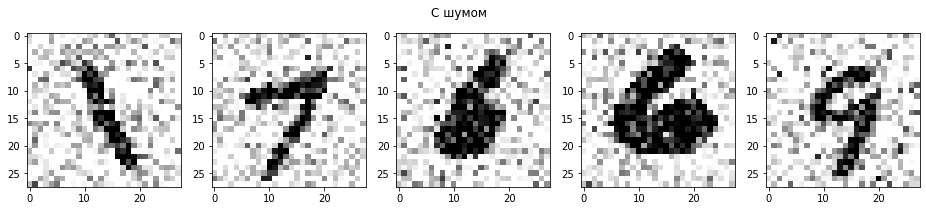

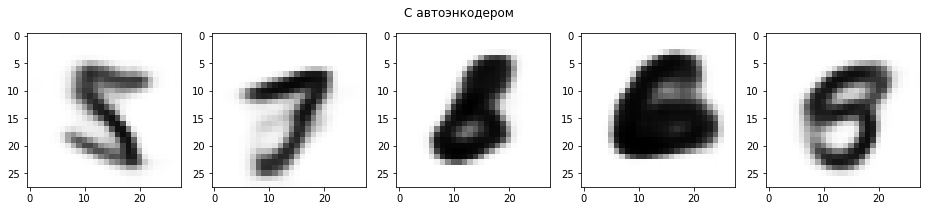

In [45]:
sample_indices = np.random.choice(x_test.shape[0], 5)
samples_noisy = x_test_noisy[sample_indices]
samples_decoded = np.squeeze(fake_VAE.predict(samples_noisy), axis = 3)
plot_images(samples_noisy, "С шумом")
plot_images(samples_decoded, "С автоэнкодером")

In [39]:
import time

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(fake_VAE, train_x, tf.keras.optimizers.Adam(learning_rate=0.001))
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(fake_VAE, test_x))
  print('Epoch: {}, Test set loss: {}, time elapse for current epoch: {:.3}'
        .format(epoch, loss.result(), end_time - start_time))

Epoch: 1, Test set loss: 0.03130778670310974, time elapse for current epoch: 54.0
Epoch: 2, Test set loss: 0.0286911241710186, time elapse for current epoch: 53.8
Epoch: 3, Test set loss: 0.026603588834404945, time elapse for current epoch: 53.3
Epoch: 4, Test set loss: 0.0261458158493042, time elapse for current epoch: 55.2
Epoch: 5, Test set loss: 0.02506403811275959, time elapse for current epoch: 53.9
Epoch: 6, Test set loss: 0.025514457374811172, time elapse for current epoch: 54.1
Epoch: 7, Test set loss: 0.024699421599507332, time elapse for current epoch: 53.5
Epoch: 8, Test set loss: 0.02421358786523342, time elapse for current epoch: 53.7
Epoch: 9, Test set loss: 0.024567559361457825, time elapse for current epoch: 54.7
Epoch: 10, Test set loss: 0.024226831272244453, time elapse for current epoch: 53.6


Теперь пришло время проверить, удалось ли нам вручную проводить обучение и обучить не хуже автоматических инструментов. Для этого сделаем проверку, как для автоэнкодера.

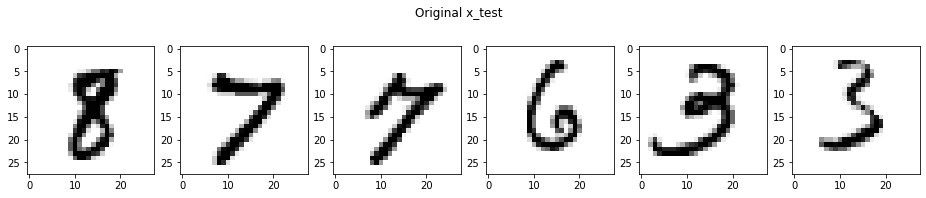

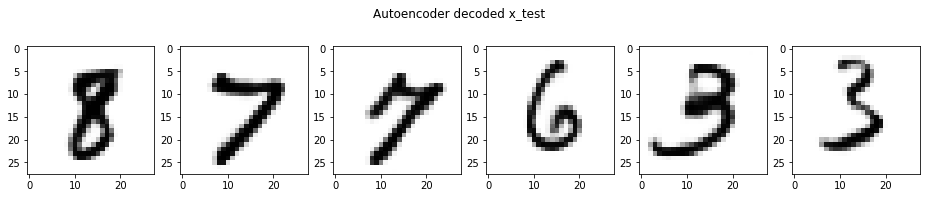

In [34]:
samples_decoded = np.squeeze(fake_VAE.predict(x_test[sample_indices]), axis = 3)
plot_images(samples_orig, "Original x_test")
plot_images(samples_decoded, "Autoencoder decoded x_test")

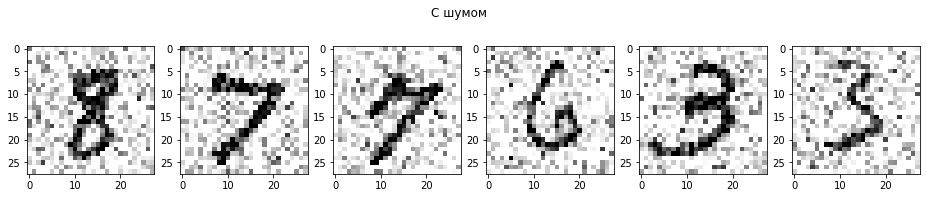

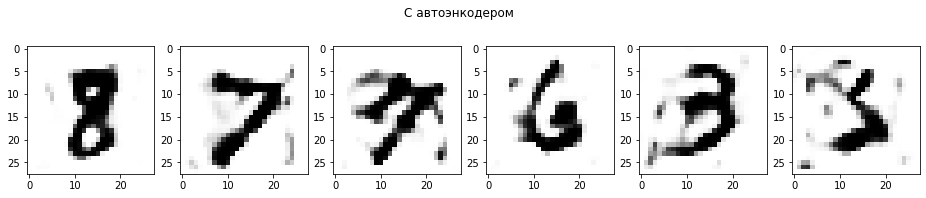

In [36]:
samples_decoded = np.squeeze(fake_VAE.predict(samples_noisy), axis = 3)
plot_images(samples_noisy, "С шумом")
plot_images(samples_decoded, "С автоэнкодером")

print()

In [ ]:
sam

Мы смогли получить то же, что и раньше с автоэнкодером. Теперь нам нужно добавить вариации и репараметризацию. Меняются 2 вещи: модель и функция потерь.

Меняется модель VAE, так как теперь не половина выходов энкодера это входы декодера, а все выходы это параметры для генерации точки в латентном пространстве, а уже она вход для декодера. Это сложно оформить моделью tensorflow. Для удобной передачи, как раньше в виде объекта, создадим объект VAE для обучения и использования. Этот объект позволит нам получать trainable_variables, которые нужны в обучении.

Для начала покажем как энкодер передаёт сигнал декодеру на необученной сети. Для этого нам не нужна репараметризация, ведь мы не будем считать градиенты или обратное распространение ошибки.
Цепочка расчёта у нас из 3 звеньев: энкодер, генерация точки в латентном пространстве, передача этой точки на декодер. В конце визуализация, что было на входе и что на выходе.

In [ ]:
# getDecoder, getEncoder methods are already valid, and VAE_latent_size already defined

# Rebuild encoder and decoder to loose connection with previous model.
# But they are essentially the same as before.
VAE_encoder = getEncoder(VAE_latent_size * 2)
VAE_decoder = getDecoder(VAE_latent_size)

# Get probability density parameters (interpret them as such)
mean, logvar = tf.split(VAE_encoder(samples_orig), num_or_size_splits=2, axis=1)
# Instantiate encoded state statistically
z = tf.random.normal(shape=mean.shape) * tf.exp(logvar * .5) + mean
# Run decoder with dropping one dimension for visualization
samples_decoded = np.squeeze(VAE_decoder(z), axis = 3)

plot_images(samples_orig, "Original x_test")
plot_images(samples_decoded, "Fresh VAE decoded x_test")

Теперь то же самое в виде класса. Если есть способ из входа сделать выход, то назовём его recode(), а для потерь нужно только добавить MSE. Также добавим репараметризацию, как функцию, для наглядности.

In [ ]:
class VAE_larva(tf.keras.Model):
    """Variational autoencoder larva."""
    
    def __init__(self, latent_dim):
        super(VAE_larva, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = getEncoder(2 * latent_dim)
        self.decoder = getDecoder(latent_dim)
        self.mse = tf.keras.losses.MeanSquaredError()
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def recode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z)
        
    def compute_loss(self, x):
        return self.mse(x, self.recode(x))

vael = VAE_larva(VAE_latent_size)

Цикл обучения почти не поменялся. Только вызываем мы теперь методы класса, а не внешние функции.

In [ ]:
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = model.compute_loss(x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(vael, train_x, tf.keras.optimizers.Adam(learning_rate=0.001))
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(vael.compute_loss(test_x))
  print('Epoch: {}, Test set loss: {}, time elapse for current epoch: {}'
        .format(epoch, -loss.result(), end_time - start_time))

Мы выучили вариационный автоэнкодер, но без регуляризации. Поэтому пока никаких улучшений ожидать не стоит. Не добавлена еще дивергенция KL в функцию потерь. Но снова можно проверить, что он обучился не хуже предыдущих автоэнкодеров.

In [ ]:
samples_decoded = np.squeeze(vael.recode(samples_orig), axis = 3)

plot_images(samples_orig, "Original x_test")
plot_images(samples_decoded, "VAE larva decoded x_test")

## Оптимизация дивергенции KL через нижнюю границу вариации (ELBO)
Дивергенция KL штука сложная. Надо считать интеграл. Однако минимизация KL достигается при максимизации нижней границы вариации. Подробней об этом написано в википедии: https://en.wikipedia.org/wiki/Evidence_lower_bound Прелесть этого перехода задачи оптимизации в том, что оптимизацию параметров латентного распределения можно делать по наблюдаемым декодированным объектам, когда объекты в латентном пространстве недоступны.
$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$
Дальше, не вдаваясь в математику, регуляторная функция будет следующая:
$$\log p(x|z) + \log p(z) - \log q(z|x),$$
где $z$ это сэмпл из $q(z|x)$.
Введём вспомогательную функцию `log_normal` для вычисления логарифма правдоподобия попадания элемента в нормальное распределение вероятностей.

In [ ]:
class VAE(tf.keras.Model):
    """Variational autoencoder finally."""
    
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = getEncoder(2 * latent_dim)
        self.decoder = getDecoder(latent_dim)
        self.mse = tf.keras.losses.MeanSquaredError()
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def recode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z)
        
    def compute_loss(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, logvar)
        x_out = self.decoder(z)
        logpx_z = -self.mse(x, x_out)
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)
        return -tf.reduce_mean(10*logpx_z + logpz - logqz_x)
    
    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)

    
vae = VAE(VAE_latent_size)

По сути наша новая функция потерь это потери на некорректное восстановление изображения + потери на неточное попадание `z` в нормальное распределение с центром в нуле и единичной дисперсией - потери на неточное попадание `z` в нормальное распределение со средним и дисперсией, сгенерированных энкодером.

In [ ]:
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(vae, train_x, tf.keras.optimizers.Adam(learning_rate=0.001))
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(vae.compute_loss(test_x))
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, -loss.result(), end_time - start_time))

Проверим, наконец, что вариационный автоэнкодер работает как автоэнкодер, визуализировав привычным способом перекодированные изображения.

In [ ]:
samples_decoded = np.squeeze(vae.recode(samples_orig), axis = 3)

plot_images(samples_orig, "Original x_test")
plot_images(samples_decoded, "VAE decoded x_test")

Если мы используем размерность латентного пространства 2, то это позволит нам получать распределение классов цифр на плоскости, типа такого:
![https://www.tensorflow.org/tutorials/generative/cvae_files/output_F-ZG69QCZnGY_0.png](https://www.tensorflow.org/tutorials/generative/cvae_files/output_F-ZG69QCZnGY_0.png)
Это не просто интерполяция по двум направлениям. Тут именно все 10 цифр должны так занять место на плоскости, чтобы плавно перетекать друг в друга.

## Задание 1
Примени автоэнкодер для освобождения картинок от шума, как мы делали в PCA, но подбери размерность латентного пространства. Какой метод фильтрации шума лучше работает: PCA или AE? Какая была размерность латентного пространства?

## Задание 2 опциональное, усложнённое
Исправить регуляризацию в последнем VAE, чтобы он заработал. При этом использовать ссылки, визуализацию латентного пространства, интуицию, опираться на работающий без регуляризации AE. В результате сеть автоэнкодера должна смочь делать плавную интерполяцию между генерируемыми изображениями. Покажи 2 видео (или 2 набора картинок) перехода между цифрами: для автоэнкодера и для вариационного автоэнкодера (VAE).

## Ссылки
Более подробно про PCA и ссылка на его применение для MNIST. https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

Введение в вариационные автоэнкодеры через автоэнкодеры, PCA https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

Википедия по дивергенции Кульбака-Лейблера https://ru.wikipedia.org/wiki/Расстояние_Кульбака_—_Лейблера

Википедия по нижней границе вариации https://en.wikipedia.org/wiki/Evidence_lower_bound

Туториал по VAE от Google по tensorflow https://www.tensorflow.org/tutorials/generative/cvae